In [ ]:
#2024.6.26更新
#用346再做一遍
import os

folder_path = '/home/lihaoxing/500k_matrix_bed/346'  # 替换为你想要遍历的文件夹的路径

for filenames in os.listdir(folder_path):
    filename = os.path.join(folder_path, filenames)
    filename_part1 = filename.split('/')
    filename_part2 = filename_part1[5].split('_')
    print(filename_part2[0])
    with open('/home/lihaoxing/jupyter/500k_bin_range.txt', 'r') as f1:
        for line1 in f1.readlines():
            chr,min_bin,max_bin = line1.strip().split('\t')
            delta = int(int(min_bin)-1)
            # 处理每一行的内容，例如打印第一个字
            #print(chr,min_bin,max_bin)
            with open(filename, 'r') as f2:
                for line2 in f2.readlines():
                    bin1,bin2,counts = line2.strip().split('\t')
                    if int(min_bin) <=int(bin1) <=int(int(max_bin)-1) and int(min_bin) <=int(bin2) <=int(int(max_bin)-1):
                        #print(bin1+"\t"+bin2+"\t"+counts+"\n")
                        with open('/home/lihaoxing/try_scHiCluster/346_cell_matrix_500k/chr'+chr+"/"+filename_part2[0]+'_chr'+chr+'.txt', 'a') as f3:
                            f3.write(str(int(bin1)-int(delta))+"\t"+str(int(bin2)-int(delta))+"\t"+counts+"\n")

In [ ]:
#2024.6.26更新
#用346再做一遍
#随后在bash中运行如下命令
conda activate schicluster
res=500000
ls /home/lihaoxing/500k_matrix_bed/346/* |awk -F '/' '{print$6}'|awk -F '_' '{print$1}' >346_cell_list.txt

#首先创建文件夹
for c in `seq 1 18`; do mkdir -p 346_cell_matrix_500k/chr${c}/; done
for c in `seq 1 18`; do mkdir -p 346_imputed_matrix_500k/chr${c}/; done
mkdir 346_imputed_matrix_500k/filelist/
mkdir -p 346_imputed_matrix_500k/merged/embed/

#下面的命令写在sh脚本里,用nohup运行，需要很长时间
cat 346_cell_list.txt |while read line; do for c in `seq 1 18`; do command time hicluster impute-cell --indir 346_cell_matrix_500k/chr${c}/ --outdir 346_imputed_matrix_500k/chr${c}/ --cell $line --chrom ${c} --res 500000 --chrom_file /home/lihaoxing/HiC-Pro-3.1.0/annotation/Sus_scrofa.chrom.schicluster.size; done; done

awk -F "-" '{print $0"\t"$1}' 346_cell_list.txt > 346_cell_type.txt

for c in `seq 1 18`; do awk -v c=$c '{printf("346_imputed_matrix_500k/chr%s/%s_chr%s_pad1_std1_rp0.5_sqrtvc.hdf5\n",c,$1,c)}' 346_cell_type.txt > 346_imputed_matrix_500k/filelist/imputelist_pad1_std1_rp0.5_sqrtvc_chr${c}.txt; echo $c; done


#下面的命令会报错`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
#需要将/home/lihaoxing/miniconda3/lib/python3.9/site-packages/schicluster/draft/embed_concatcell_chr.py中的np.str修改为str
for c in `seq 1 18`; do command time hicluster embed-concatcell-chr --cell_list 346_imputed_matrix_500k/filelist/imputelist_pad1_std1_rp0.5_sqrtvc_chr${c}.txt --outprefix 346_imputed_matrix_500k/merged/embed/pad1_std1_rp0.5_sqrtvc_chr${c} --res 500000; done

ls 346_imputed_matrix_500k/merged/embed/*npy > 346_imputed_matrix_500k/filelist/embedlist_pad1_std1_rp0.5_sqrtvc.txt

#需要将/home/lihaoxing/miniconda3/lib/python3.9/site-packages/schicluster/draft/embed_mergechr.py 中的np.str修改为str
command time hicluster embed-mergechr --embed_list 346_imputed_matrix_500k/filelist/embedlist_pad1_std1_rp0.5_sqrtvc.txt --outprefix 346_imputed_matrix_500k/merged/embed/pad1_std1_rp0.5_sqrtvc

2025-04-14 19:08:39.228275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14 19:08:52.375438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


6


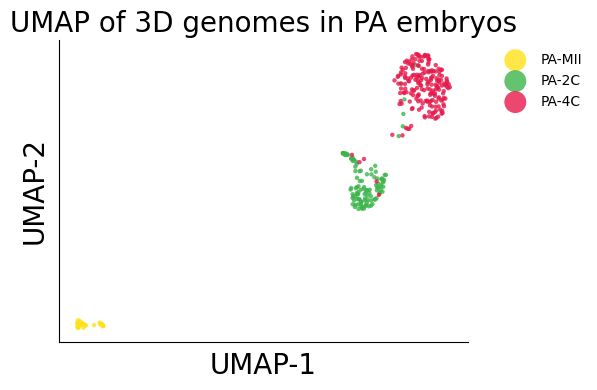

In [1]:
#PA 500K 346cells 
import h5py
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans  # 导入KMeans
from umap import UMAP
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import SVG, display

#mpl.style.use('default')
#mpl.rcParams['pdf.fonttype'] = 42
#mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'

# 自定义颜色
color_map = {
    "MII": "#ffe119",  # 黄色
    "2C": "#3cb44b",   # 绿色
    "4C":  "#e6194b"   # 红色
}

# 加载嵌入数据
with h5py.File('/home/lihaoxing/try_scHiCluster/346_imputed_matrix_500k/merged/embed/pad1_std1_rp0.5_sqrtvc.svd20.hdf5', 'r') as f:
    matrix_reduce = f['data'][()]

# 确定使用的维度数量
for ndim in range(100):
    p = ks_2samp(matrix_reduce[:, ndim], matrix_reduce[:, ndim + 1]).pvalue
    if p > 0.01:
        break

ndim += 1
print(ndim)
ndim = 20  # 手动设置维度数量
umap = UMAP(n_neighbors=25, random_state=0)
y = umap.fit_transform(matrix_reduce[:, :ndim])

# 加载标签数据
label = pd.read_csv('/home/lihaoxing/try_scHiCluster/346_cell_type.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

# 进行聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(matrix_reduce[:, :ndim])
label['cluster'] = kmeans.labels_ + 1

# 保存UMAP坐标和标签到CSV
umap_df = pd.DataFrame(y, columns=['UMAP-1', 'UMAP-2'])
umap_df['Cell_ID'] = label['batch'].values
umap_df['Cell_Type'] = label[1].values
umap_df['Cluster'] = label['cluster'].values
umap_df.to_csv('346_500k_umap_embeddings.csv', index=True)

# 绘图
ds = 10
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('UMAP-1', fontsize=20)
ax.set_ylabel('UMAP-2', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('UMAP of 3D genomes in PA embryos', fontsize=20)

# 绘制散点图
for cell_type, color in color_map.items():
    cell = (label[1] == cell_type)
    ax.scatter(
        y[cell, 0],
        y[cell, 1],
        c=color,
        s=ds,
        edgecolors='none',
        alpha=0.8,
        label=f"PA-{cell_type}",  # 修改图例标注
        rasterized=True
    )

# 调整图例
ax.legend(
    markerscale=5,
    prop={'size': 10},
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=15,
    frameon=False
)

# 自动调整布局
plt.tight_layout()

# 保存图像
plt.savefig('PA_346_500k.svg', dpi=300, bbox_inches='tight', transparent=True)



6


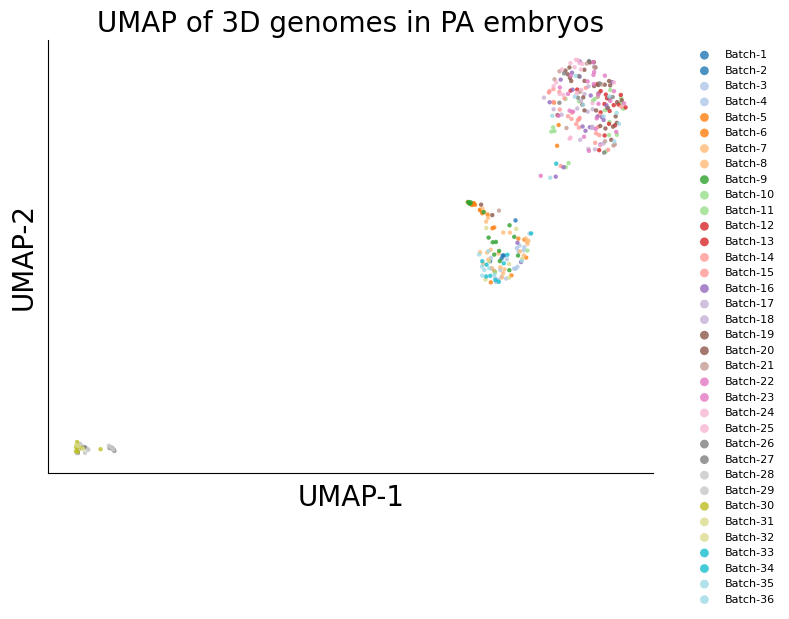

In [7]:
# PA 500K 346cells 
import h5py
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# 加载嵌入数据
with h5py.File('/home/lihaoxing/try_scHiCluster/346_imputed_matrix_500k/merged/embed/pad1_std1_rp0.5_sqrtvc.svd20.hdf5', 'r') as f:
    matrix_reduce = f['data'][()]

# 确定使用的维度数量
for ndim in range(100):
    p = ks_2samp(matrix_reduce[:, ndim], matrix_reduce[:, ndim + 1]).pvalue
    if p > 0.01:
        break

ndim += 1
print(ndim)
ndim = 20  # 手动设置维度数量
umap = UMAP(n_neighbors=25, random_state=0)
y = umap.fit_transform(matrix_reduce[:, :ndim])

# 加载标签数据
label = pd.read_csv('/home/lihaoxing/try_scHiCluster/346_cell_batch.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

# 根据第二列为细胞批次分配颜色
batch_values = label[1].unique()  # 获取所有的第二列值

# 为每个批次生成唯一的颜色
colors = plt.cm.get_cmap('tab20', len(batch_values))  # 使用“tab20”调色盘生成指定数量的颜色
color_map = {batch_value: colors(i) for i, batch_value in enumerate(batch_values)}

# 进行聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(matrix_reduce[:, :ndim])
label['cluster'] = kmeans.labels_ + 1

# 保存UMAP坐标和标签到CSV
umap_df = pd.DataFrame(y, columns=['UMAP-1', 'UMAP-2'])
umap_df['Cell_ID'] = label['batch'].values
umap_df['Cell_Type'] = label[1].values
umap_df['Cluster'] = label['cluster'].values
umap_df.to_csv('346_500k_umap_embeddings.csv', index=True)

# 绘图
ds = 10
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('UMAP-1', fontsize=20)
ax.set_ylabel('UMAP-2', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('UMAP of 3D genomes in PA embryos', fontsize=20)

# 绘制散点图
for batch_value, color in color_map.items():
    cell = (label[1] == batch_value)
    ax.scatter(
        y[cell, 0],
        y[cell, 1],
        color=color,  # 为每个批次使用分配的颜色
        s=ds,
        edgecolors='none',
        alpha=0.8,
        label=f"Batch-{batch_value}",  # 用第二列值作为图例标注
        rasterized=True
    )

# 调整图例
ax.legend(
    markerscale=2,
    prop={'size': 8},
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10,
    frameon=False
)

# 自动调整布局
plt.tight_layout()

# 保存图像
plt.savefig('PA_346_500k.pdf', dpi=300)
plt.show()


In [2]:
# Print cell IDs for each cluster
for cluster_label in label['cluster'].unique():
    cluster_cells = label[label['cluster'] == cluster_label].index
    print(f'Cluster {cluster_label} Cell IDs:')
    print(cluster_cells)


Cluster 1 Cell IDs:
Index(['2-101-2', '2-10-1', '2-104-2', '2-105-1', '2-105-2', '2-106-1',
       '2-106-2', '2-108-1', '2-109-1', '2-109-2',
       ...
       'PB-7-2', 'PB-8-1', 'Y4-1-3', 'Y4-20-1', 'Y4-20-2', 'Y4-4-1', 'Y4-4-2',
       'Y4-7-2', 'Y4-7-3', 'Y4-7-4'],
      dtype='object', name=0, length=344)
Cluster 3 Cell IDs:
Index(['4-253-1'], dtype='object', name=0)
Cluster 2 Cell IDs:
Index(['4-264-3'], dtype='object', name=0)


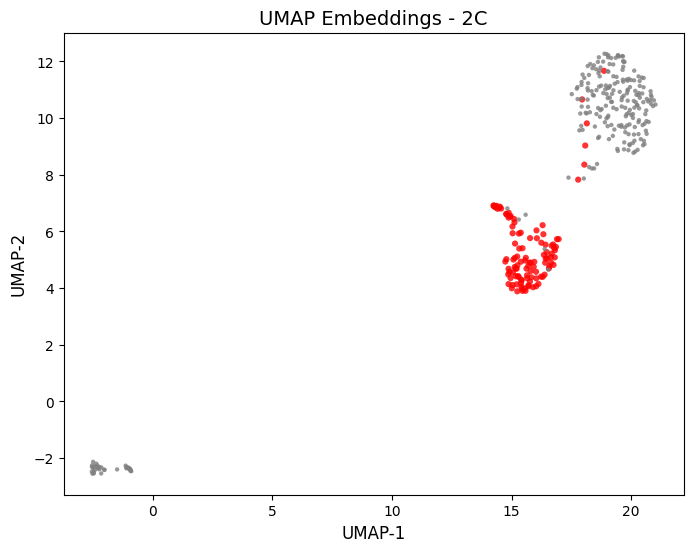

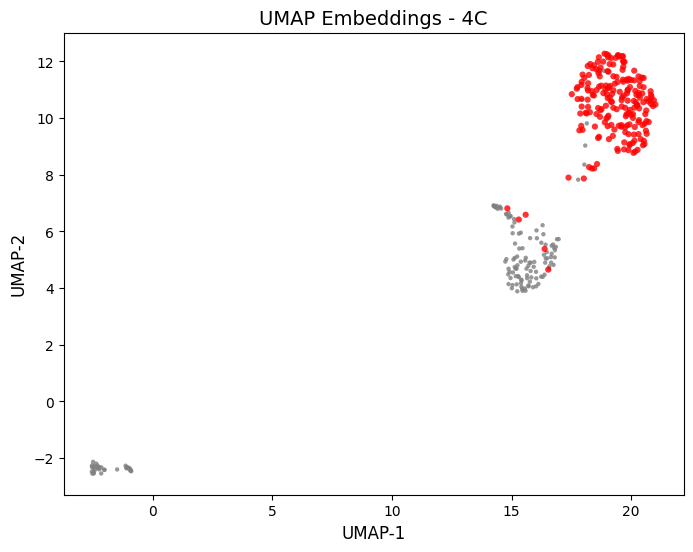

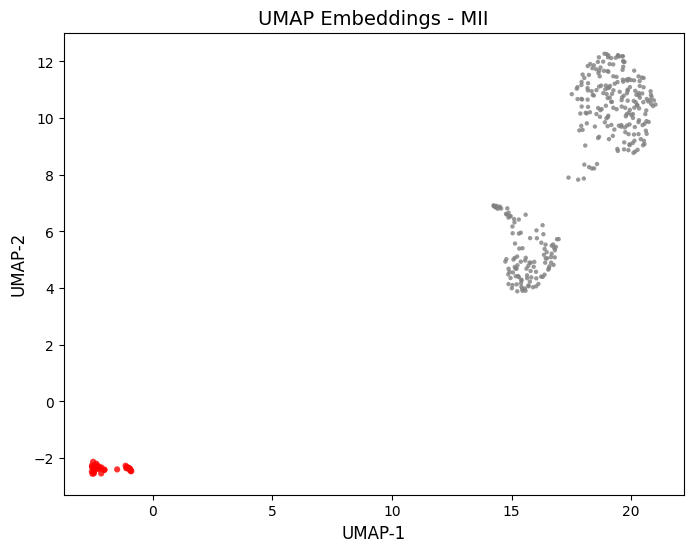

In [10]:
#查看不同批次数据
# Plot UMAP embeddings with each cell type highlighted in red in separate subplots
unique_cell_types = label[1].unique()

for cell_type in unique_cell_types:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlabel('UMAP-1', fontsize=12)
    ax.set_ylabel('UMAP-2', fontsize=12)
    ax.set_title(f'UMAP Embeddings - {cell_type}', fontsize=14)
    
    for i, curr_cell_type in enumerate(unique_cell_types):
        cell = (label[1] == curr_cell_type)
        if curr_cell_type == cell_type:
            ax.scatter(y[cell, 0], y[cell, 1], c='red', s=ds*2, edgecolors='none', alpha=0.8, label=curr_cell_type, rasterized=True)
        else:
            ax.scatter(y[cell, 0], y[cell, 1], c='gray', s=ds, edgecolors='none', alpha=0.8, label=curr_cell_type, rasterized=True)
    
    #ax.legend(title='Cell Type', fontsize=10)
    plt.show()


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]


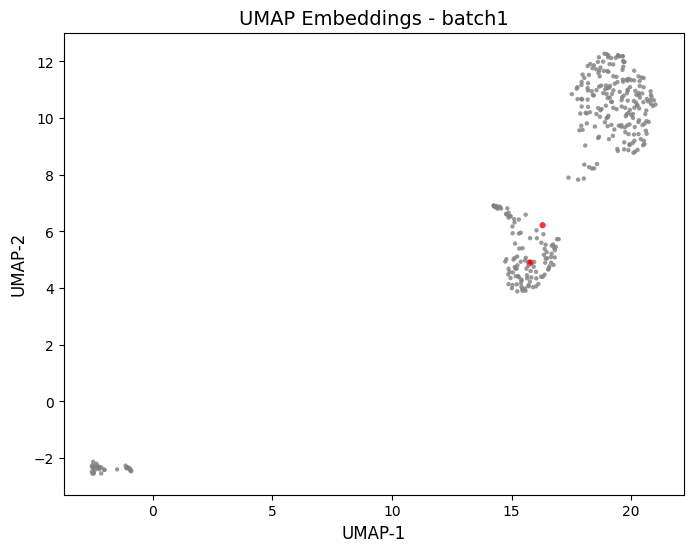

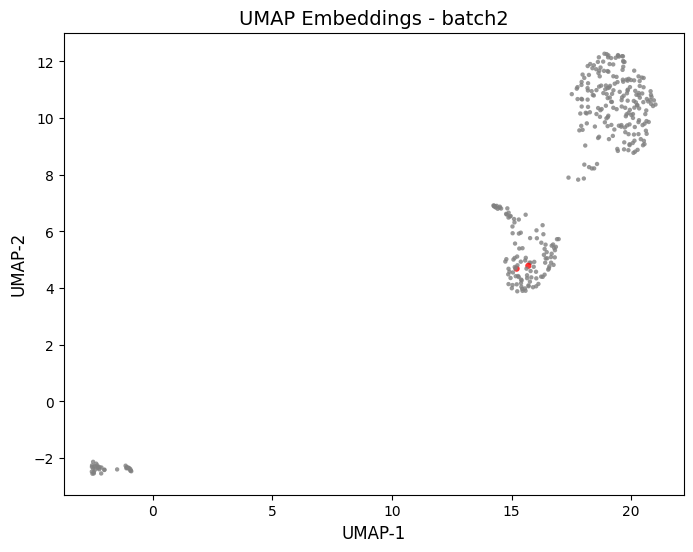

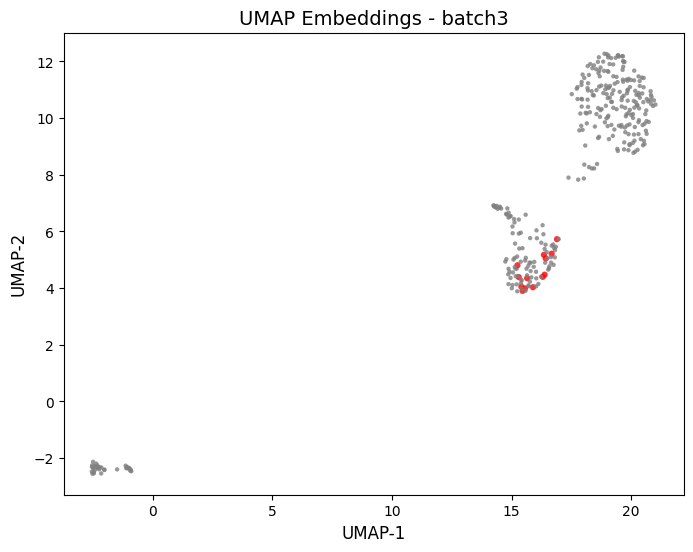

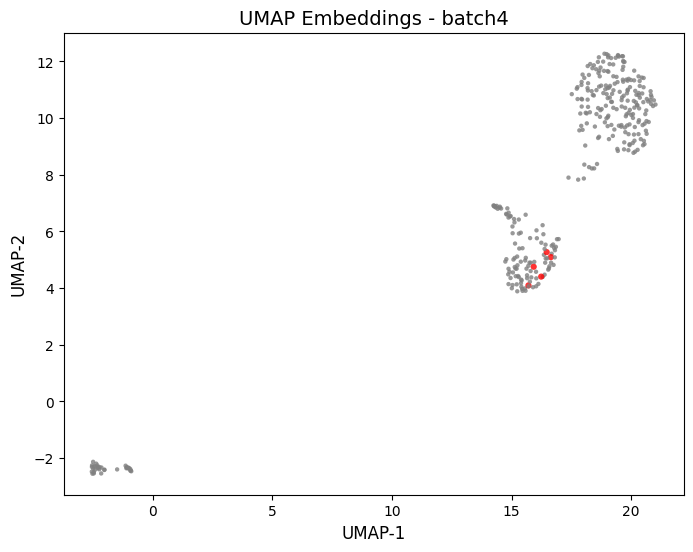

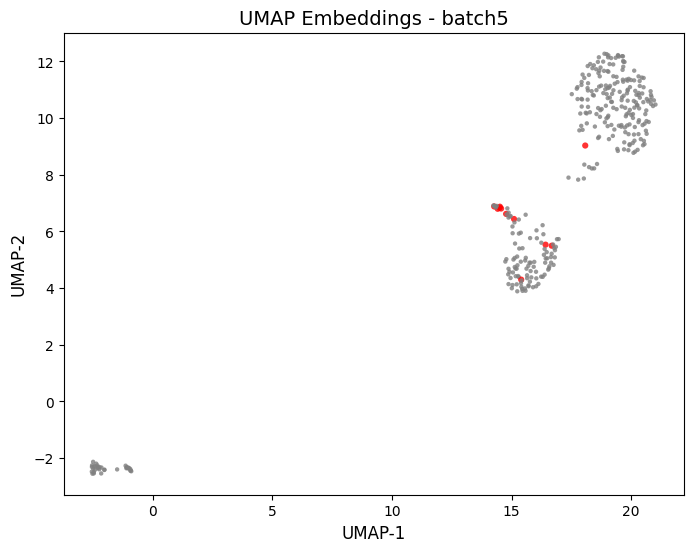

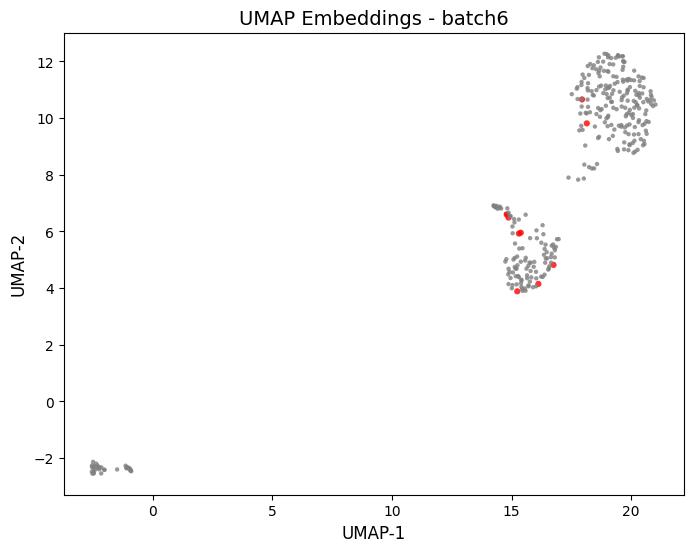

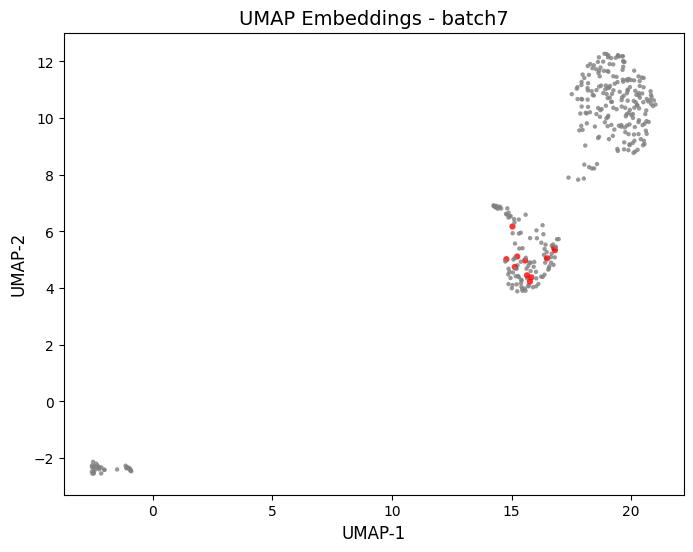

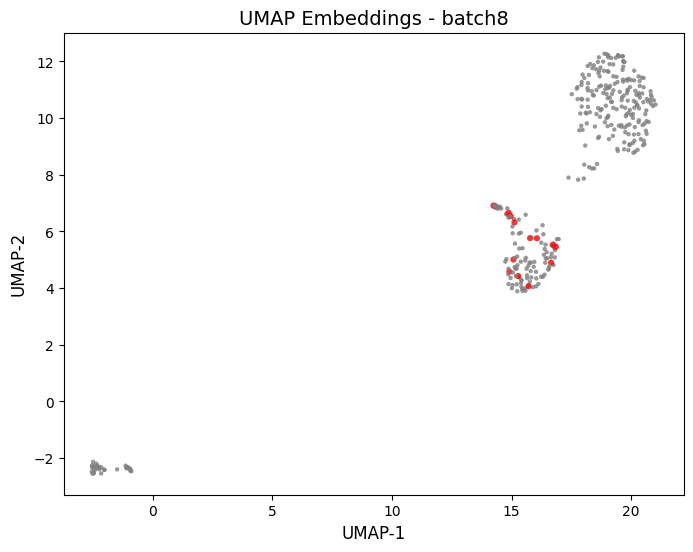

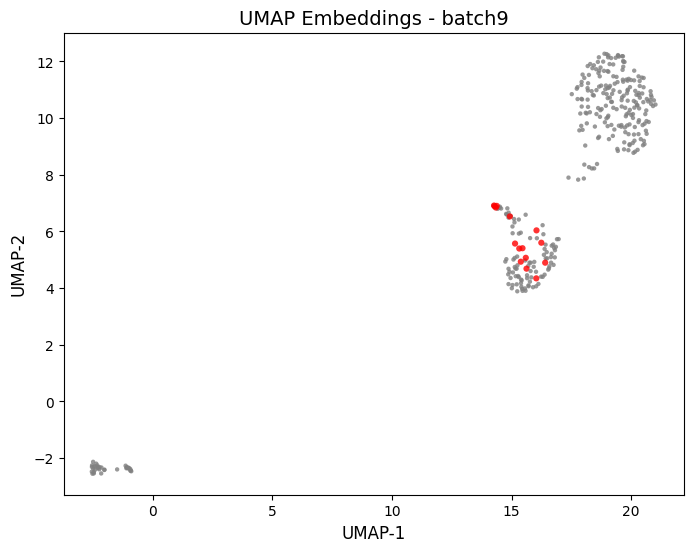

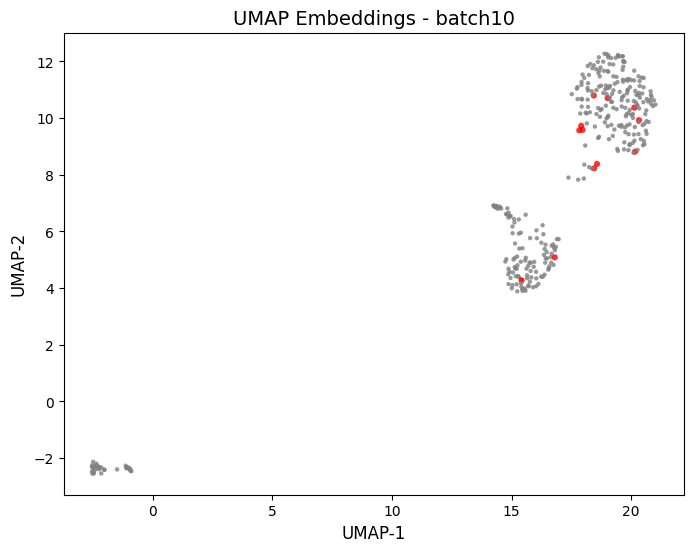

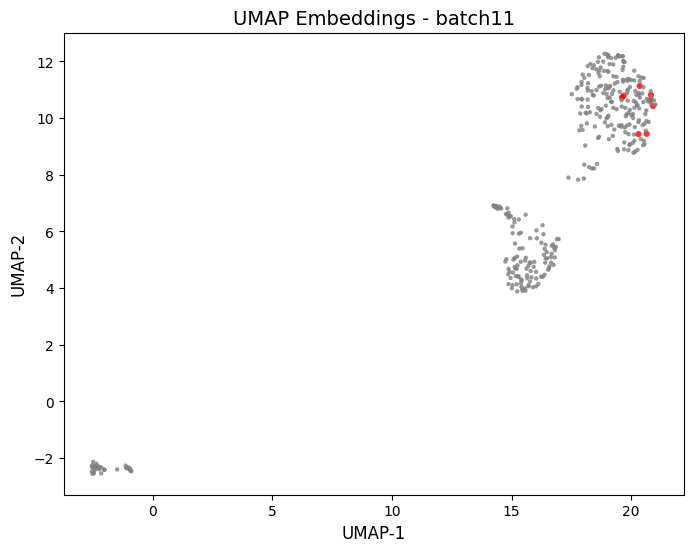

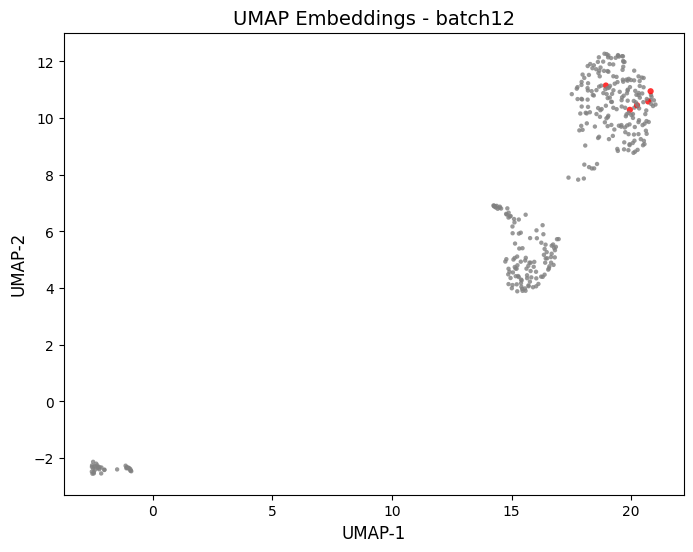

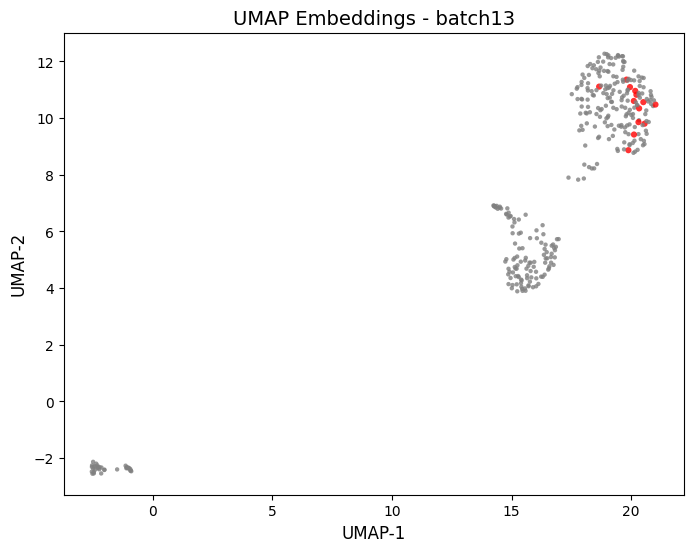

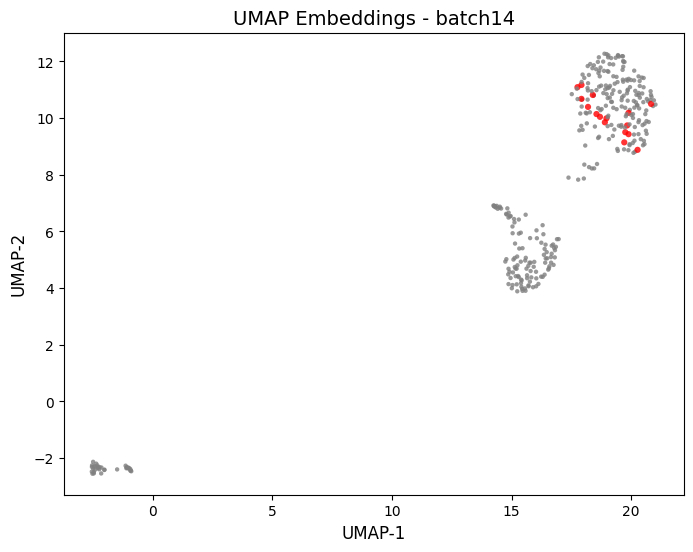

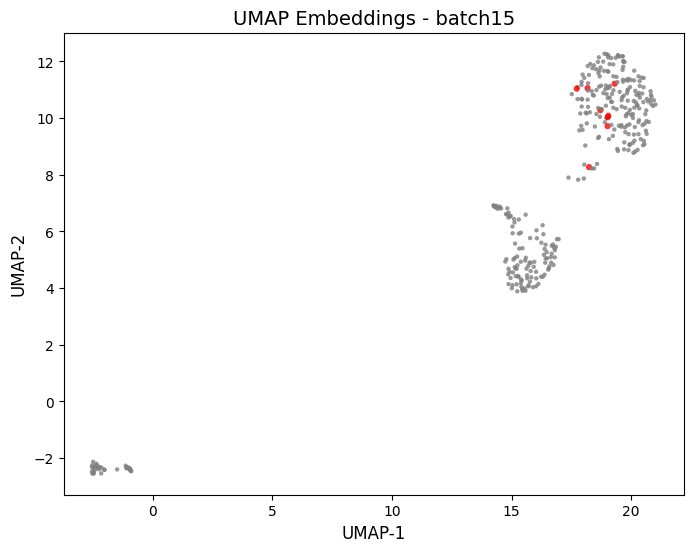

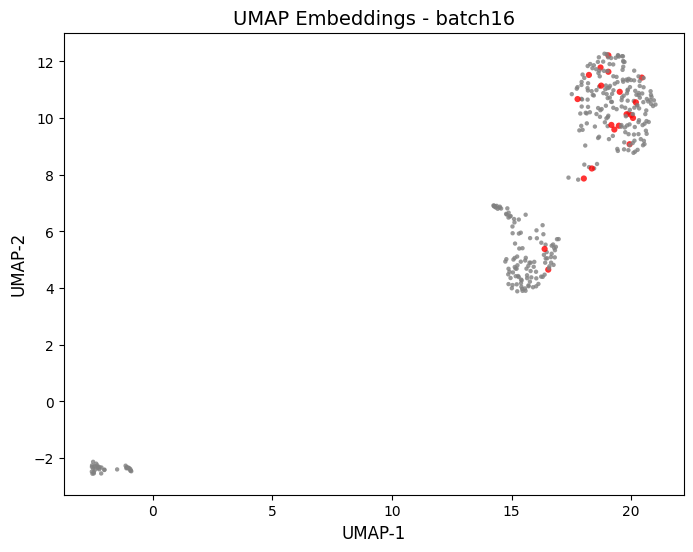

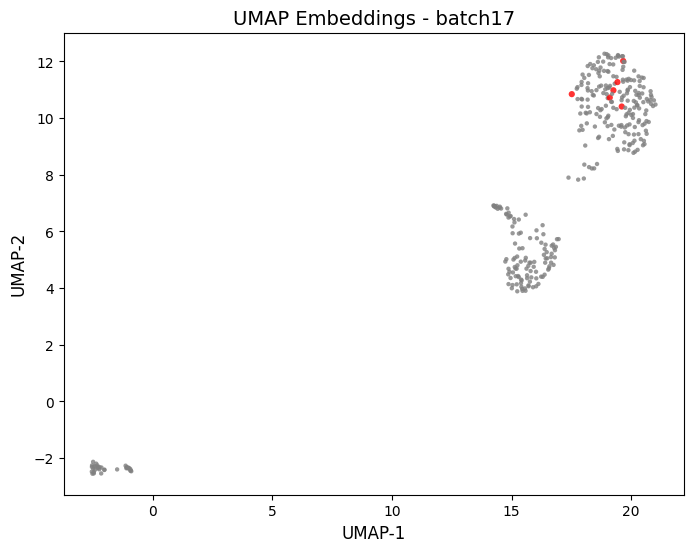

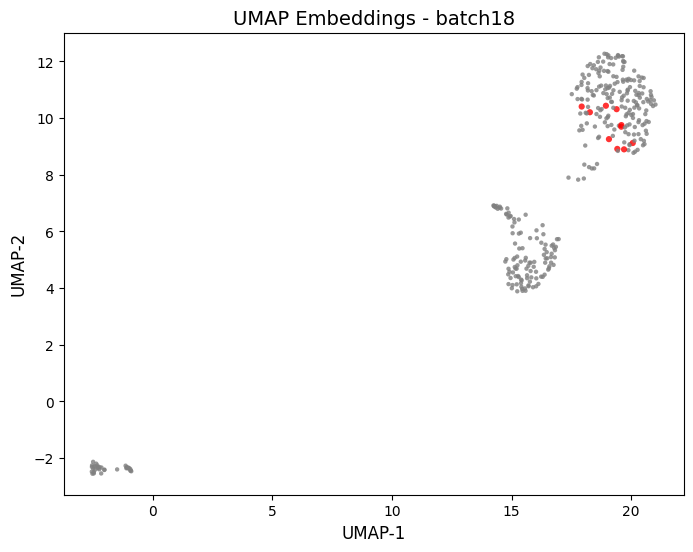

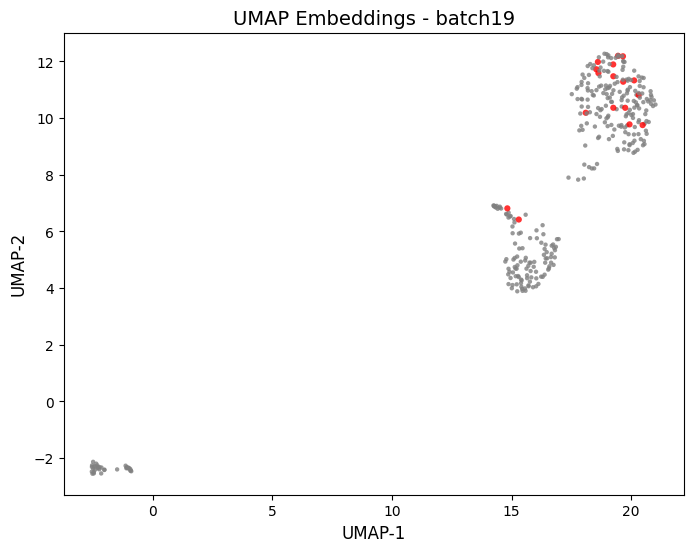

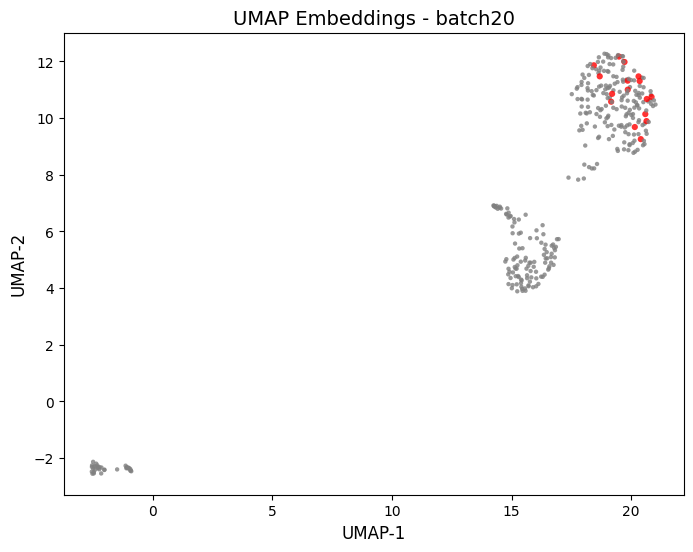

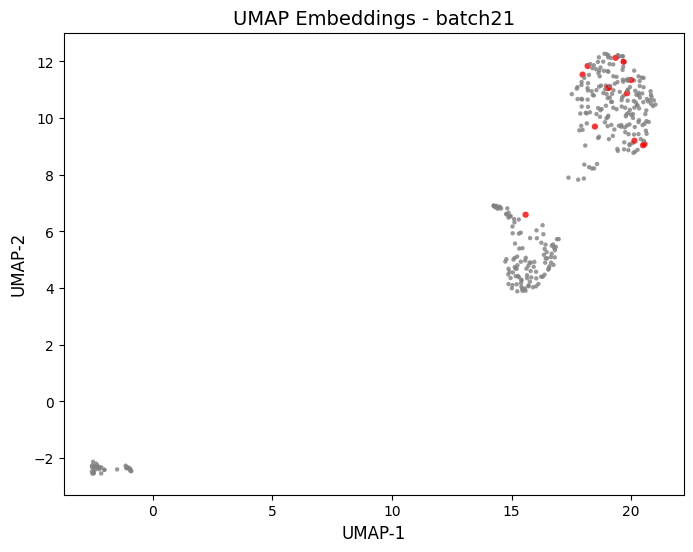

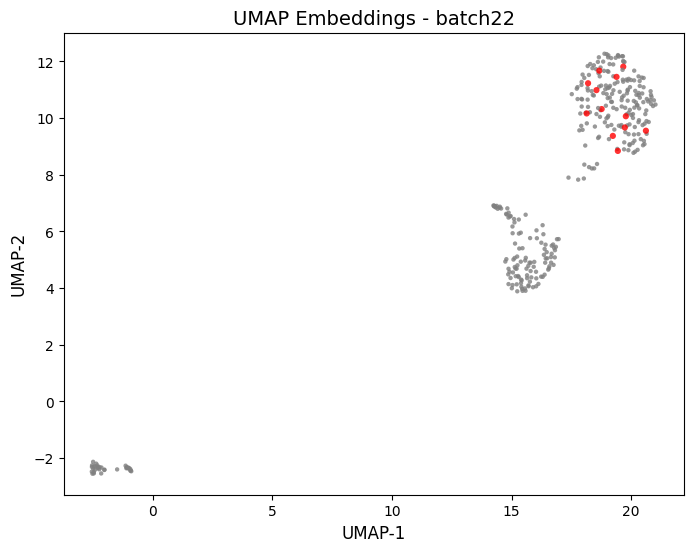

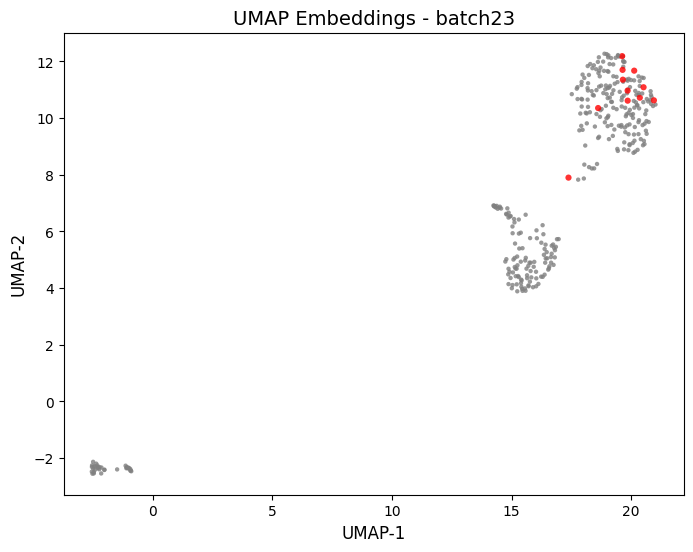

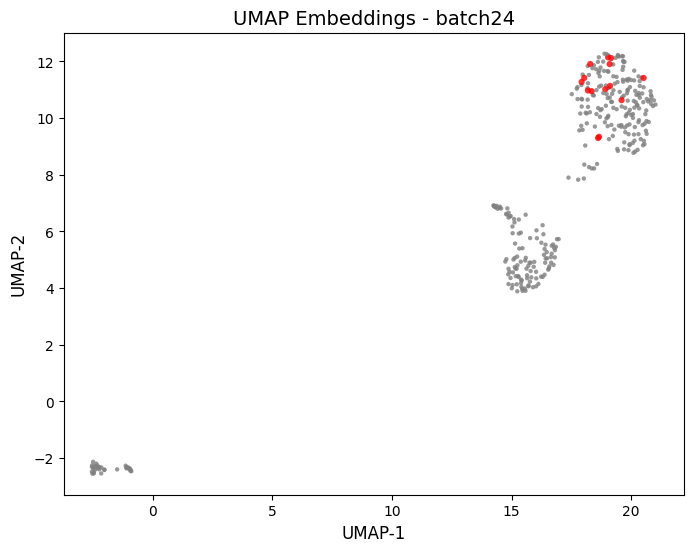

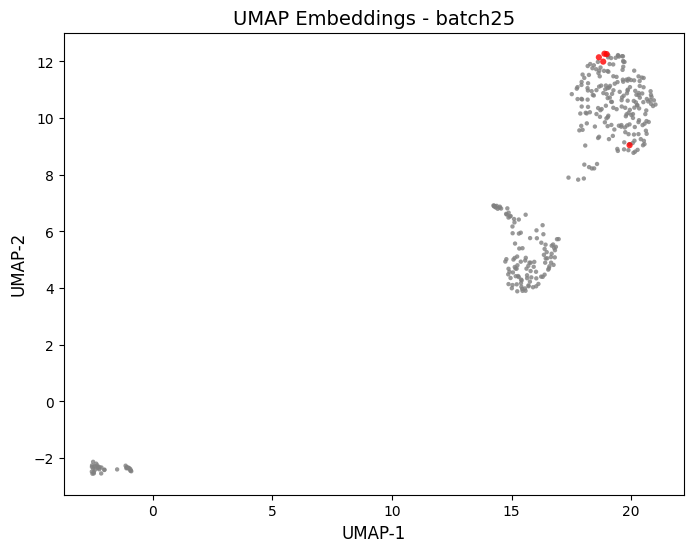

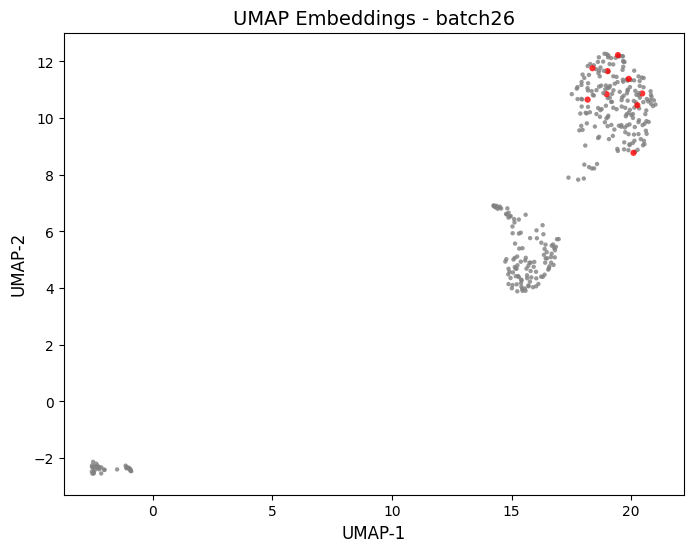

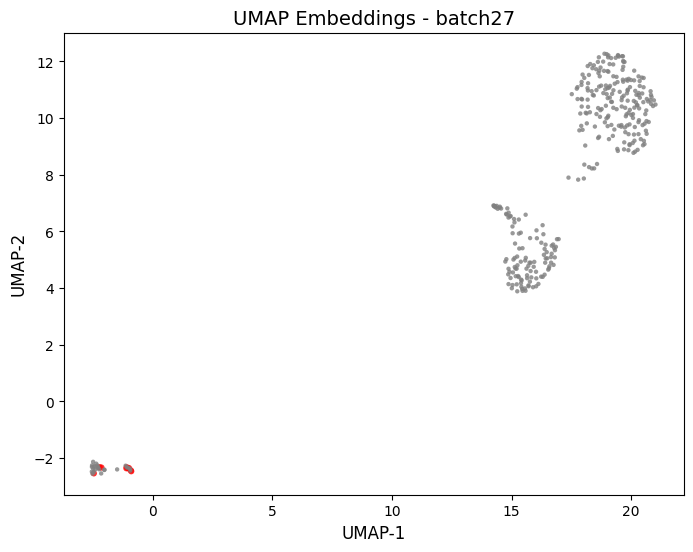

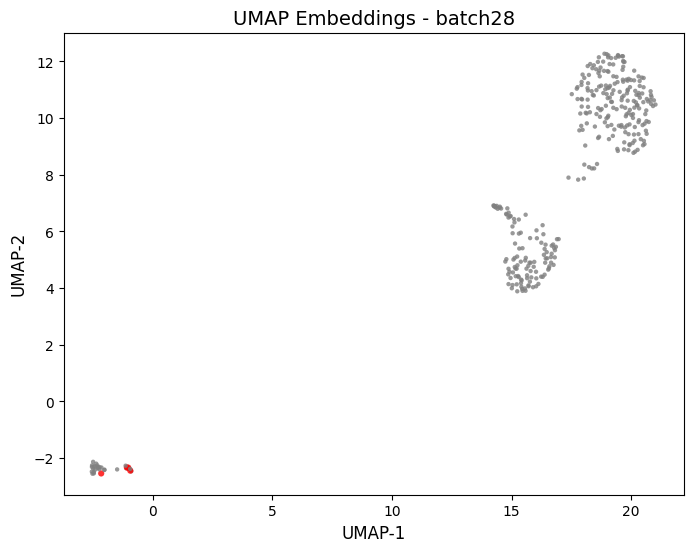

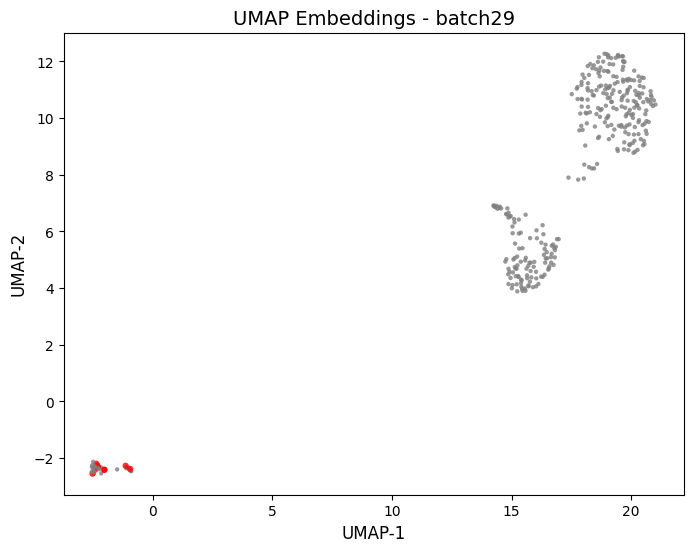

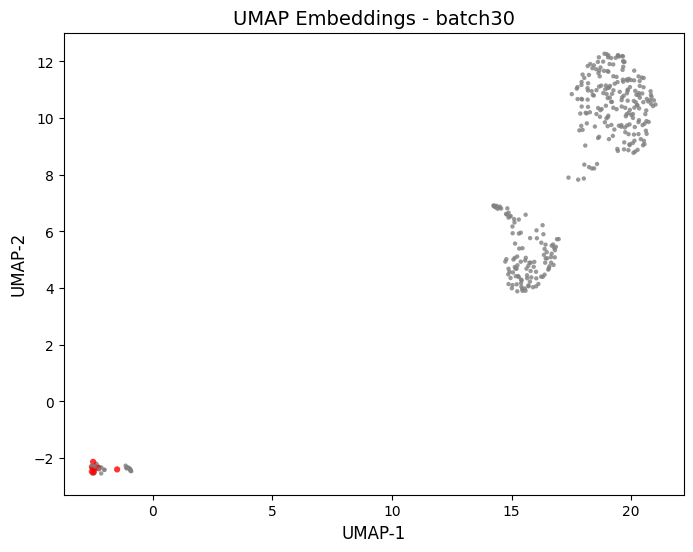

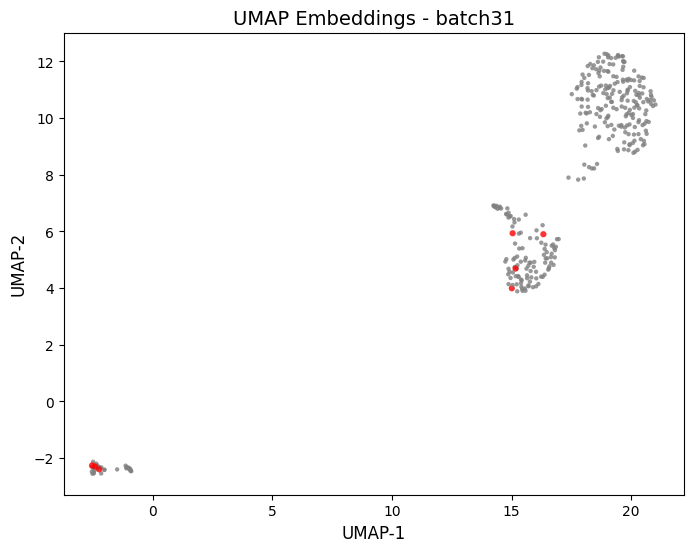

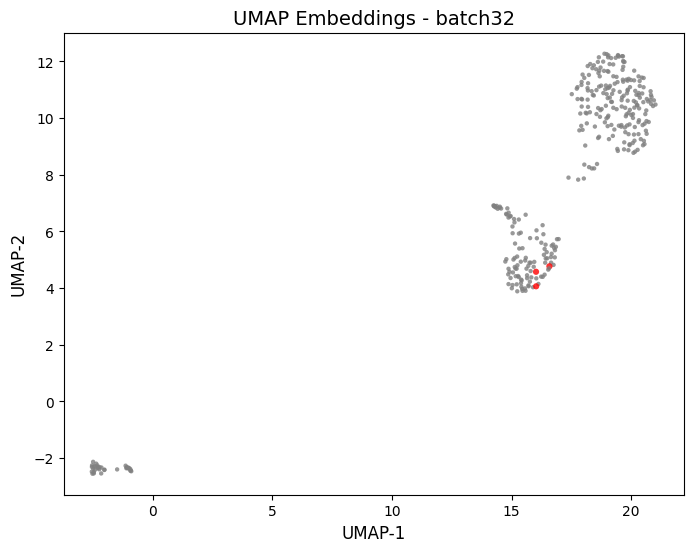

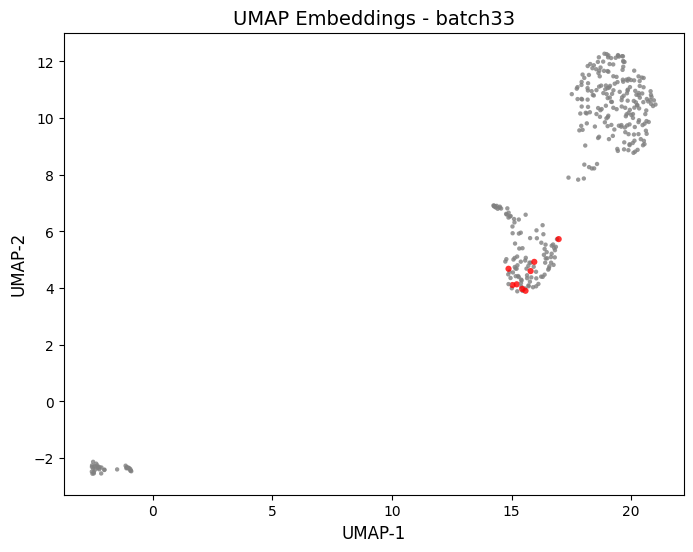

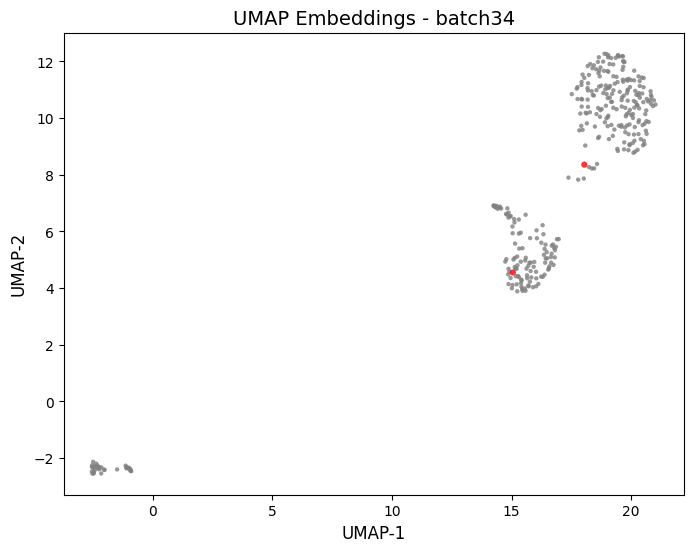

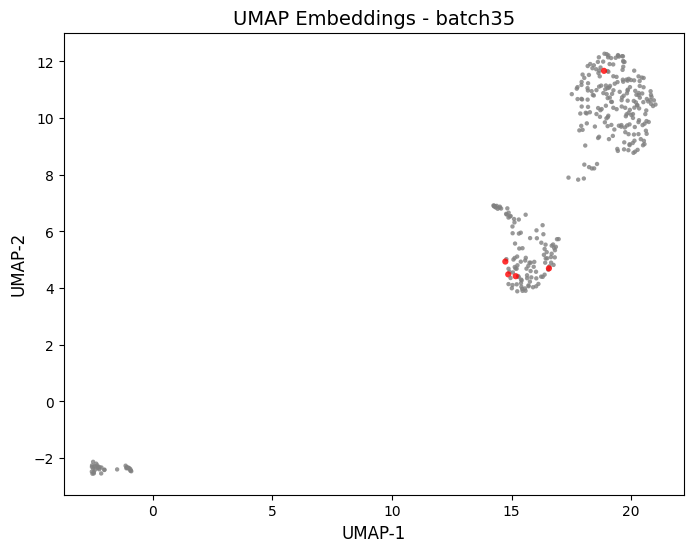

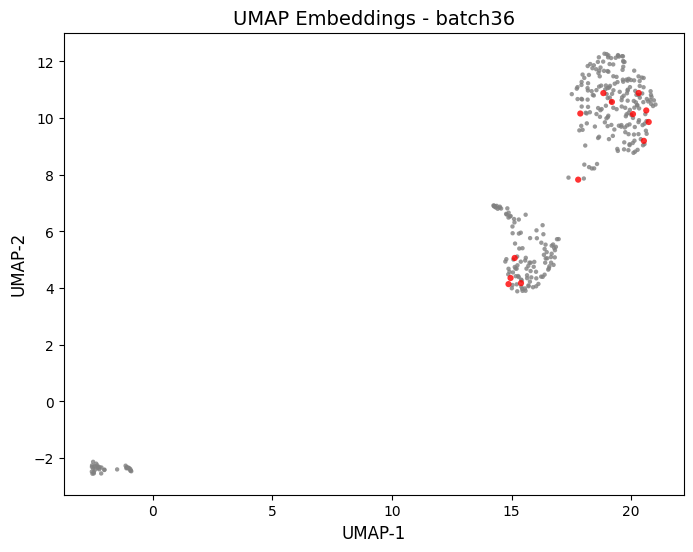

In [8]:
#PA 500K 346cells 获取数据批次标签

# 加载标签数据
label = pd.read_csv('/home/lihaoxing/try_scHiCluster/346_cell_batch.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

#查看不同批次数据
# Plot UMAP embeddings with each cell type highlighted in red in separate subplots
unique_cell_types = label[1].unique()
print(unique_cell_types)
for cell_type in unique_cell_types:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlabel('UMAP-1', fontsize=12)
    ax.set_ylabel('UMAP-2', fontsize=12)
    ax.set_title(f'UMAP Embeddings - batch{cell_type}', fontsize=14)
    
    for i, curr_cell_type in enumerate(unique_cell_types):
        cell = (label[1] == curr_cell_type)
        if curr_cell_type == cell_type:
            ax.scatter(y[cell, 0], y[cell, 1], c='red', s=ds*2, edgecolors='none', alpha=0.8, label=curr_cell_type, rasterized=True)
        else:
            ax.scatter(y[cell, 0], y[cell, 1], c='gray', s=ds, edgecolors='none', alpha=0.8, label=curr_cell_type, rasterized=True)
    
    #ax.legend(title='Cell Type', fontsize=10)
    plt.show()


In [20]:
#打印出图中每个细胞的数量
ax = axes[0]
for i, x in enumerate(label[1].value_counts().index):
    cell = (label[1] == x)
    ax.scatter(y[cell, 0], y[cell, 1], c=color[i], s=ds, edgecolors='none', alpha=0.8, label=x, rasterized=True)
num_points_per_cell_type = [np.sum(cell) for cell in (label[1] == x for x in label[1].value_counts().index)]

ax.legend(markerscale=5, prop={'size': 10}, bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)

# 统计每个 Cluster 子图中的散点数量
ax = axes[1]
for i, x in enumerate(label['cluster'].value_counts().index):
    cell = (label['cluster'] == x)
    ax.scatter(y[cell, 0], y[cell, 1], c='C' + str(i), s=ds, edgecolors='none', alpha=0.8, label=x, rasterized=True)
num_points_per_cluster = [np.sum(cell) for cell in (label['cluster'] == x for x in label['cluster'].value_counts().index)]

ax.legend(markerscale=5, prop={'size': 10}, bbox_to_anchor=(1, 1), loc='upper left', fontsize=20)

# 打印每个子图中的散点数量
print("Number of points per Cell Type:", num_points_per_cell_type)
print("Number of points per Cluster:", num_points_per_cluster)

Number of points per Cell Type: [203, 103, 20]
Number of points per Cluster: [295, 30, 1]


In [5]:
#IVF 350,500k,2024年11月28日

import os

folder_path = '/home/lihaoxing/IVF_500k_matrix'  # 替换为你想要遍历的文件夹的路径

for filenames in os.listdir(folder_path):
    filename = os.path.join(folder_path, filenames)
    filename_part1 = filename.split('/')
    filename_part2 = filename_part1[4].split('_')
    print(filename_part2[0])
    with open('/home/lihaoxing/jupyter/500k_bin_range.txt', 'r') as f1:
        for line1 in f1.readlines():
            chr,min_bin,max_bin = line1.strip().split('\t')
            delta = int(int(min_bin)-1)
            # 处理每一行的内容，例如打印第一个字
            #print(chr,min_bin,max_bin)
            with open(filename, 'r') as f2:
                for line2 in f2.readlines():
                    bin1,bin2,counts = line2.strip().split('\t')
                    if int(min_bin) <=int(bin1) <=int(int(max_bin)-1) and int(min_bin) <=int(bin2) <=int(int(max_bin)-1):
                        #print(bin1+"\t"+bin2+"\t"+counts+"\n")
                        with open('/home/lihaoxing/try_scHiCluster/IVF350_cell_matrix_500k/chr'+chr+"/"+filename_part2[0]+'_chr'+chr+'.txt', 'a') as f3:
                            f3.write(str(int(bin1)-int(delta))+"\t"+str(int(bin2)-int(delta))+"\t"+counts+"\n")

IVF-1C-36
IVF-1C-38
IVF-1C-40
IVF-1C-41
IVF-1C-42
IVF-1C-45
IVF-1C-46
IVF-1C-49
IVF-1C-50
IVF-1C-51
IVF-1C-52
IVF-1C-55
IVF-1C-58
IVF-1C-59
IVF-1C-60
IVF-1C-61
IVF-1C-63
IVF-1C-66
IVF-1C-67
IVF-1C-69
IVF-1C-70
IVF-1C-71
IVF-1C-72
IVF-1C-73
IVF-1C-74
IVF-1C-78
IVF-1C-80
IVF-1C-90
IVF-1C-91
IVF-1C-92
IVF-1C-94
IVF-2-101-1
IVF-2-101-2
IVF-2-102-2
IVF-2-104-1
IVF-2-104-2
IVF-2-105-1
IVF-2-105-2
IVF-2-106-1
IVF-2-106-2
IVF-2-107-1
IVF-2-108-1
IVF-2-112-2
IVF-2-113-2
IVF-2-114-1
IVF-2-114-2
IVF-2-115-1
IVF-2-115-2
IVF-2-117-1
IVF-2-121-1
IVF-2-121-2
IVF-2-124-1
IVF-2-124-2
IVF-2-126-2
IVF-2-13-1
IVF-2-131-1
IVF-2-131-2
IVF-2-135-1
IVF-2-136-2
IVF-2-137-1
IVF-2-137-2
IVF-2-138-2
IVF-2-140-1
IVF-2-141-2
IVF-2-143-1
IVF-2-143-2
IVF-2-144-2
IVF-2-145-1
IVF-2-145-2
IVF-2-146-1
IVF-2-146-2
IVF-2-147-1
IVF-2-148-1
IVF-2-148-2
IVF-2-149-2
IVF-2-150-1
IVF-2-150-2
IVF-2-151-1
IVF-2-152-1
IVF-2-153-1
IVF-2-153-2
IVF-2-154-2
IVF-2-156-2
IVF-2-157-1
IVF-2-157-2
IVF-2-159-1
IVF-2-162-1
IVF-2-162-2
IVF-2-1

In [ ]:
#IVF 350,500k

#随后在bash中运行如下命令
conda activate schicluster
res=500000
ls /home/lihaoxing/IVF_500k_matrix/* |awk -F '/' '{print$5}'|awk -F '_' '{print$1}' >IVF350_cell_list.txt

#首先创建文件夹
for c in `seq 1 18`; do mkdir -p IVF350_cell_matrix_500k/chr${c}/; done
for c in `seq 1 18`; do mkdir -p IVF350_imputed_matrix_500k/chr${c}/; done
mkdir IVF350_imputed_matrix_500k/filelist/
mkdir -p IVF350_imputed_matrix_500k/merged/embed/

#下面的命令写在sh脚本里,用nohup运行，需要很长时间
cat IVF350_cell_list.txt |while read line; do for c in `seq 1 18`; do command time hicluster impute-cell --indir IVF350_cell_matrix_500k/chr${c}/ --outdir IVF350_imputed_matrix_500k/chr${c}/ --cell $line --chrom ${c} --res 500000 --chrom_file /home/lihaoxing/HiC-Pro-3.1.0/annotation/Sus_scrofa.chrom.schicluster.size; done; done

awk -F "-" '{print $0"\t"$2}' IVF350_cell_list.txt > IVF350_cell_type.txt

for c in `seq 1 18`; do awk -v c=$c '{printf("IVF350_imputed_matrix_500k/chr%s/%s_chr%s_pad1_std1_rp0.5_sqrtvc.hdf5\n",c,$1,c)}' IVF350_cell_type.txt > IVF350_imputed_matrix_500k/filelist/imputelist_pad1_std1_rp0.5_sqrtvc_chr${c}.txt; echo $c; done

#下面的命令会报错`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
#需要将/home/lihaoxing/miniconda3/lib/python3.9/site-packages/schicluster/draft/embed_concatcell_chr.py中的np.str修改为str
for c in `seq 1 18`; do command time hicluster embed-concatcell-chr --cell_list IVF350_imputed_matrix_500k/filelist/imputelist_pad1_std1_rp0.5_sqrtvc_chr${c}.txt --outprefix IVF350_imputed_matrix_500k/merged/embed/pad1_std1_rp0.5_sqrtvc_chr${c} --res 500000; done

ls IVF350_imputed_matrix_500k/merged/embed/*npy > IVF350_imputed_matrix_500k/filelist/embedlist_pad1_std1_rp0.5_sqrtvc.txt

#需要将/home/lihaoxing/miniconda3/lib/python3.9/site-packages/schicluster/draft/embed_mergechr.py 中的np.str修改为str
command time hicluster embed-mergechr --embed_list IVF350_imputed_matrix_500k/filelist/embedlist_pad1_std1_rp0.5_sqrtvc.txt --outprefix IVF350_imputed_matrix_500k/merged/embed/pad1_std1_rp0.5_sqrtvc

2


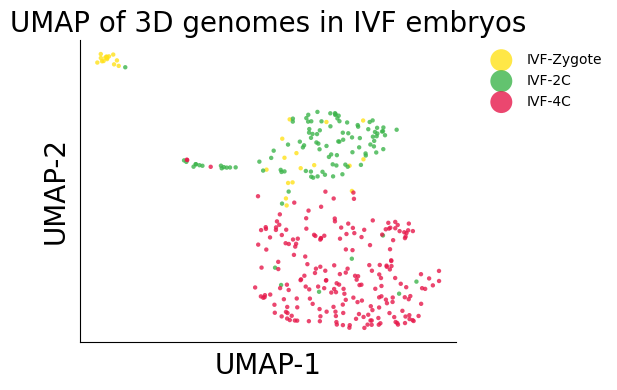

In [2]:
#IVF 350,500k
import h5py
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans  # 导入KMeans
from umap import UMAP
from itertools import cycle, islice
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from IPython.display import SVG, display

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.hashsalt'] = 'hello'


# 自定义颜色
color_map = {
    "Zygote": "#ffe119",  # 黄色
    "2C": "#3cb44b",  # 绿色
    "4C": "#e6194b"   # 红色
}

# 加载嵌入数据
with h5py.File('/home/lihaoxing/try_scHiCluster/IVF350_imputed_matrix_500k/merged/embed/pad1_std1_rp0.5_sqrtvc.svd20.hdf5', 'r') as f:
    matrix_reduce = f['data'][()]

# 确定使用的维度数量
for ndim in range(100):
    p = ks_2samp(matrix_reduce[:, ndim], matrix_reduce[:, ndim + 1]).pvalue
    if p > 0.01:
        break

ndim += 1
print(ndim)
ndim = 20  # 可手动调整维度
umap = UMAP(n_neighbors=25, random_state=0)
y = umap.fit_transform(matrix_reduce[:, :ndim])

# 加载标签数据
label = pd.read_csv('/home/lihaoxing/try_scHiCluster/IVF350_cell_type.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

# 进行聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(matrix_reduce[:, :ndim])
label['cluster'] = kmeans.labels_ + 1

# 保存UMAP坐标和标签到CSV
umap_df = pd.DataFrame(y, columns=['UMAP-1', 'UMAP-2'])
umap_df['Cell_ID'] = label['batch'].values
umap_df['Cell_Type'] = label[1].values
umap_df['Cluster'] = label['cluster'].values
umap_df.to_csv('IVF350_500k_umap_embeddings.csv', index=True)

# 绘图
ds = 10
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_xlabel('UMAP-1', fontsize=20)
ax.set_ylabel('UMAP-2', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('UMAP of 3D genomes in IVF embryos', fontsize=20)

# 按细胞类型绘制散点图
for cell_type, color in color_map.items():
    cell = (label[1] == cell_type)
    ax.scatter(
        y[cell, 0],
        y[cell, 1],
        c=color,
        s=ds,
        edgecolors='none',
        alpha=0.8,
        label=f"IVF-{cell_type}",  # 修改图例标注
        rasterized=True
    )

# 调整图例
ax.legend(
    markerscale=5,
    prop={'size': 10},
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=15,
    frameon=False
)

# 自动调整布局
plt.tight_layout()

# 保存图像
plt.savefig('IVF_350_500k.svg', dpi=300, bbox_inches='tight', transparent=True)

2


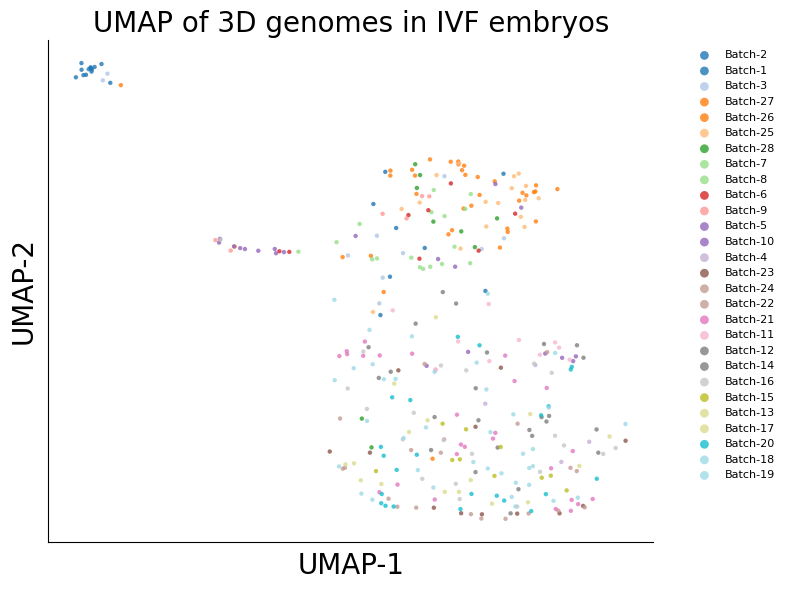

In [9]:
# IVF 350,500k batch
import h5py
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans  # 导入KMeans
from umap import UMAP
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm as cm

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# 加载嵌入数据
with h5py.File('/home/lihaoxing/try_scHiCluster/IVF350_imputed_matrix_500k/merged/embed/pad1_std1_rp0.5_sqrtvc.svd20.hdf5', 'r') as f:
    matrix_reduce = f['data'][()]

# 确定使用的维度数量
for ndim in range(100):
    p = ks_2samp(matrix_reduce[:, ndim], matrix_reduce[:, ndim + 1]).pvalue
    if p > 0.01:
        break

ndim += 1
print(ndim)
ndim = 20  # 可手动调整维度
umap = UMAP(n_neighbors=25, random_state=0)
y = umap.fit_transform(matrix_reduce[:, :ndim])

# 加载标签数据
label = pd.read_csv('/home/lihaoxing/try_scHiCluster/IVF350_cell_batch.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

# 为每个批次分配唯一的颜色
batch_values = label[1].unique()  # 获取所有的第二列值
colors = plt.cm.get_cmap('tab20', len(batch_values))  # 使用“tab20”调色盘生成指定数量的颜色
color_map = {batch_value: colors(i) for i, batch_value in enumerate(batch_values)}

# 进行聚类
kmeans = KMeans(n_clusters=3, random_state=0).fit(matrix_reduce[:, :ndim])
label['cluster'] = kmeans.labels_ + 1

# 保存UMAP坐标和标签到CSV
umap_df = pd.DataFrame(y, columns=['UMAP-1', 'UMAP-2'])
umap_df['Cell_ID'] = label['batch'].values
umap_df['Cell_Type'] = label[1].values
umap_df['Cluster'] = label['cluster'].values
umap_df.to_csv('IVF350_500k_umap_embeddings.csv', index=True)

# 绘图
ds = 10
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('UMAP-1', fontsize=20)
ax.set_ylabel('UMAP-2', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_title('UMAP of 3D genomes in IVF embryos', fontsize=20)

# 按批次绘制散点图
for batch_value, color in color_map.items():
    cell = (label[1] == batch_value)
    ax.scatter(
        y[cell, 0],
        y[cell, 1],
        color=color,  # 为每个批次使用分配的颜色
        s=ds,
        edgecolors='none',
        alpha=0.8,
        label=f"Batch-{batch_value}",  # 用第二列值作为图例标注
        rasterized=True
    )

# 调整图例
ax.legend(
    markerscale=2,
    prop={'size': 8},
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10,
    frameon=False
)

# 自动调整布局
plt.tight_layout()

# 保存图像
plt.savefig('IVF_350_500k.pdf', dpi=300)
plt.show()


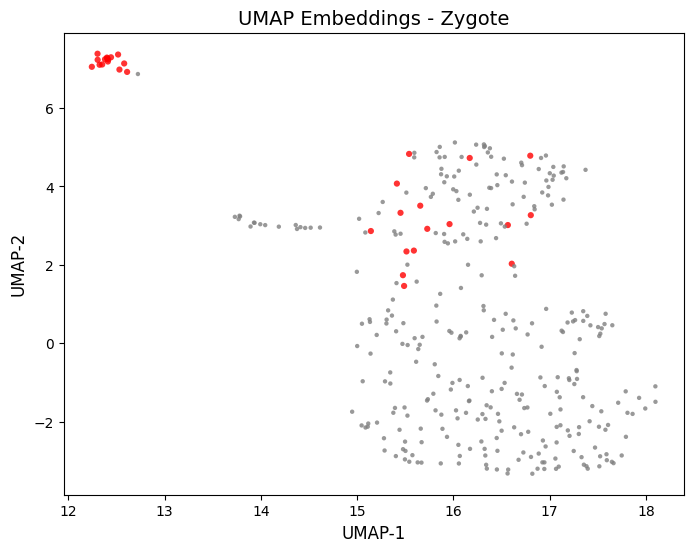

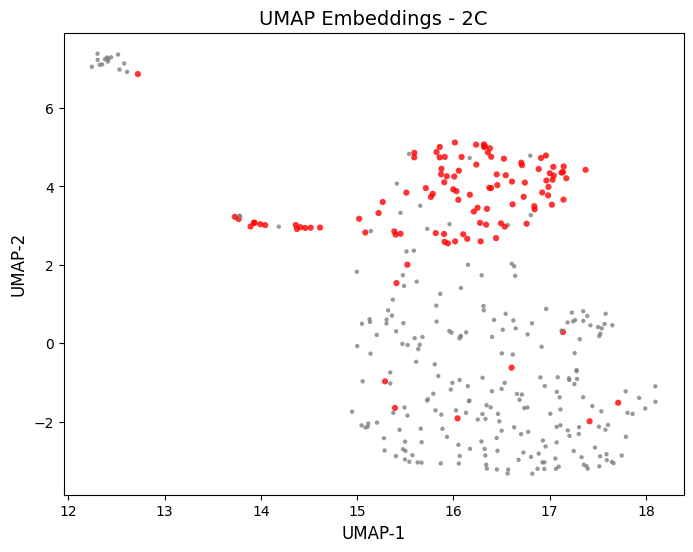

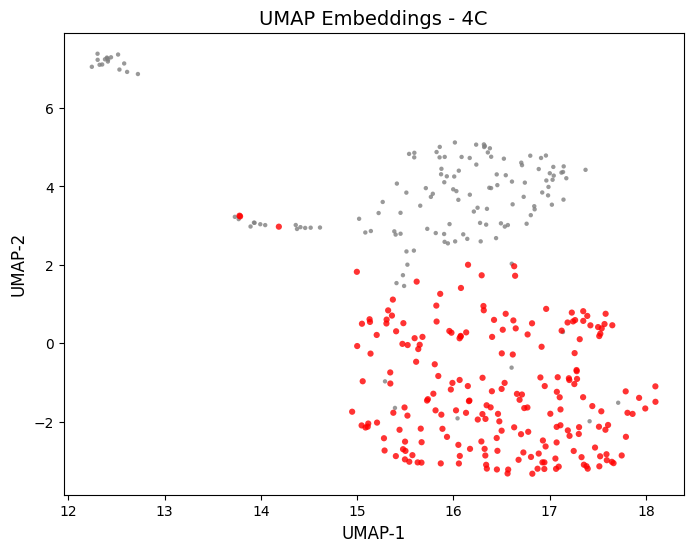

In [373]:
#查看不同批次数据
# Plot UMAP embeddings with each cell type highlighted in red in separate subplots
unique_cell_types = label[1].unique()

for cell_type in unique_cell_types:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlabel('UMAP-1', fontsize=12)
    ax.set_ylabel('UMAP-2', fontsize=12)
    ax.set_title(f'UMAP Embeddings - {cell_type}', fontsize=14)
    
    for i, curr_cell_type in enumerate(unique_cell_types):
        cell = (label[1] == curr_cell_type)
        if curr_cell_type == cell_type:
            ax.scatter(y[cell, 0], y[cell, 1], c='red', s=ds*2, edgecolors='none', alpha=0.8, label=curr_cell_type, rasterized=True)
        else:
            ax.scatter(y[cell, 0], y[cell, 1], c='gray', s=ds, edgecolors='none', alpha=0.8, label=curr_cell_type, rasterized=True)
    
    #ax.legend(title='Cell Type', fontsize=10)
    plt.show()


[ 2  1  3 27 26 25 28  7  8  6  9  5 10  4 23 24 22 21 11 12 14 16 15 13
 17 20 18 19]


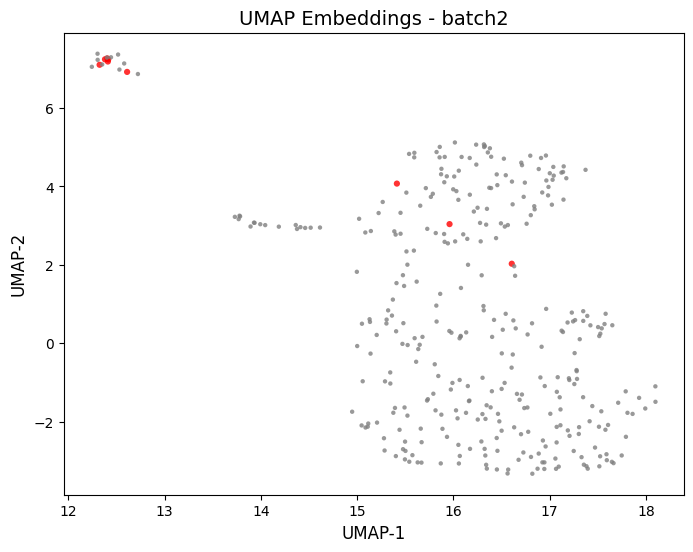

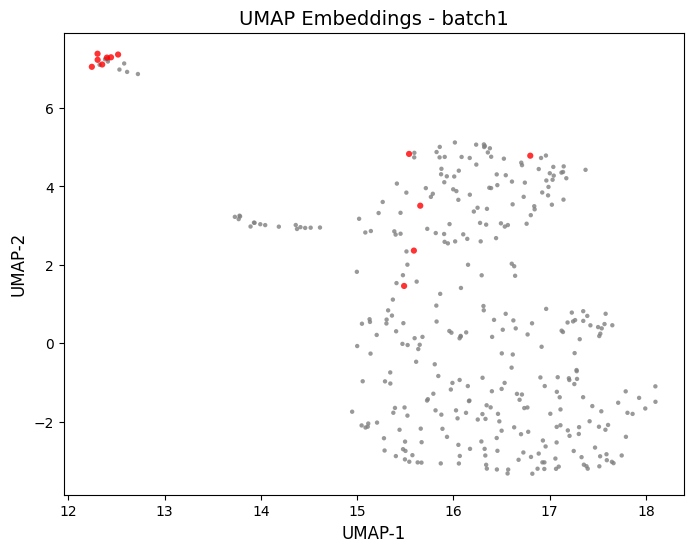

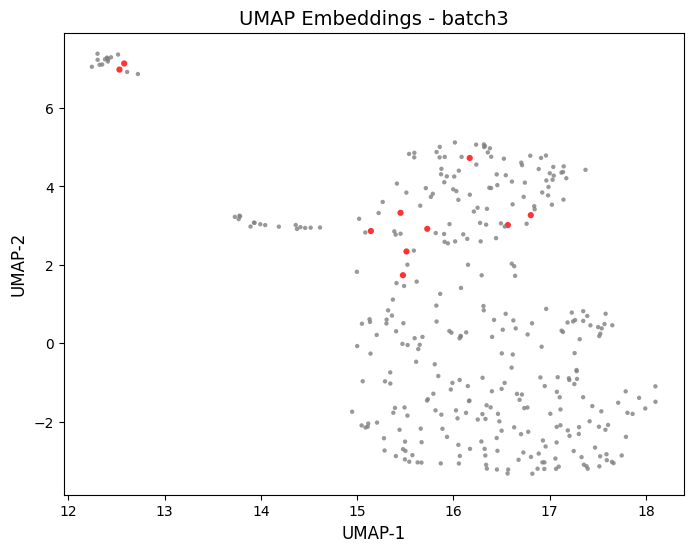

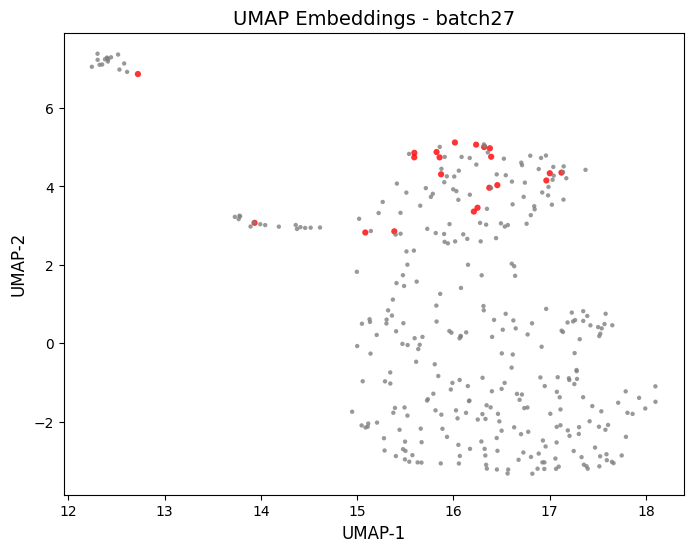

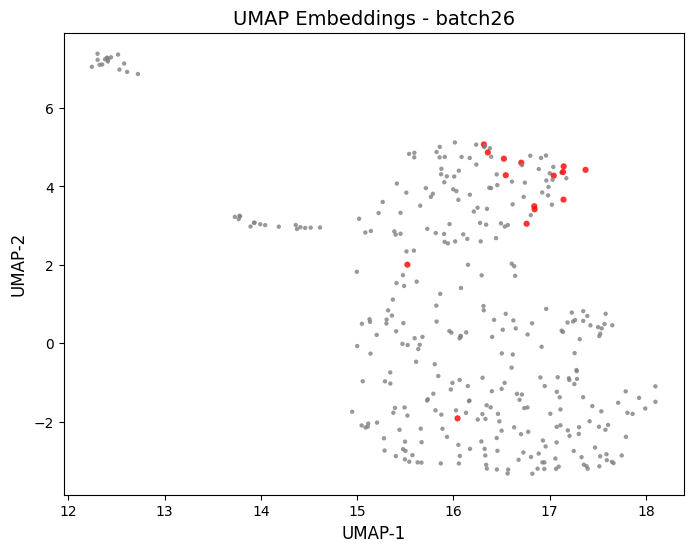

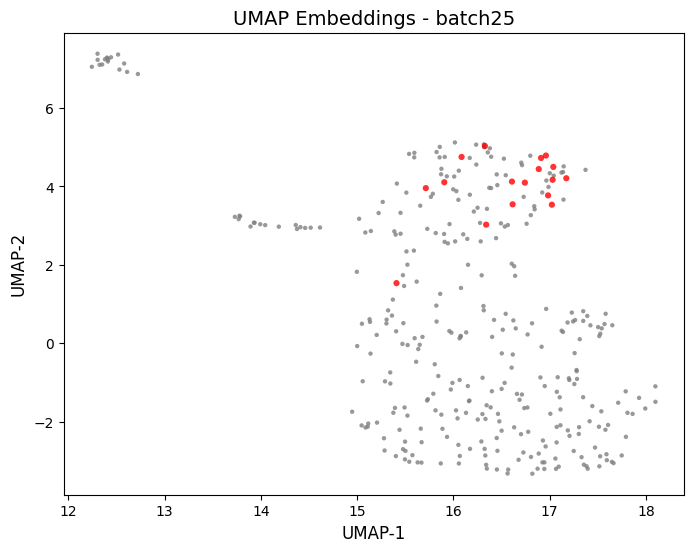

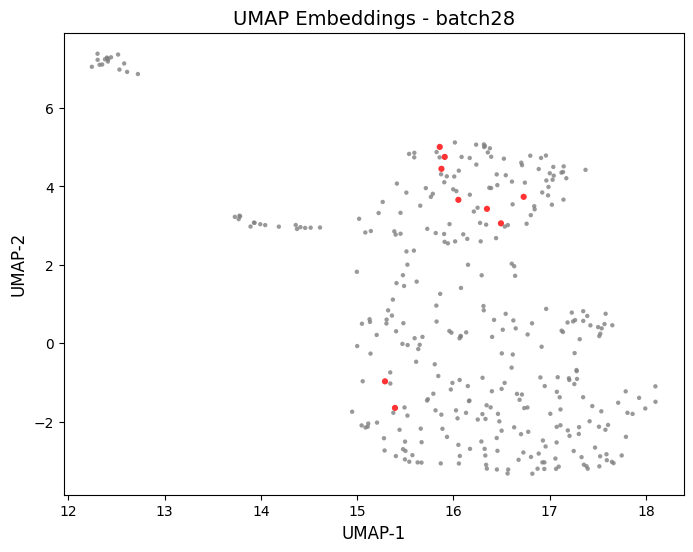

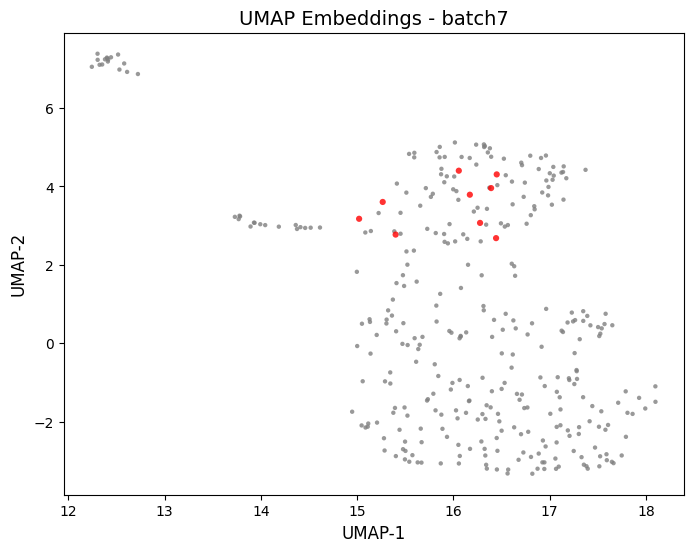

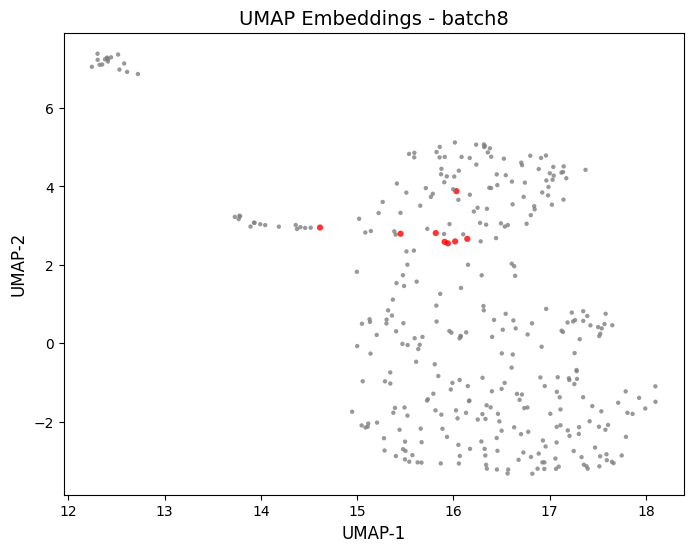

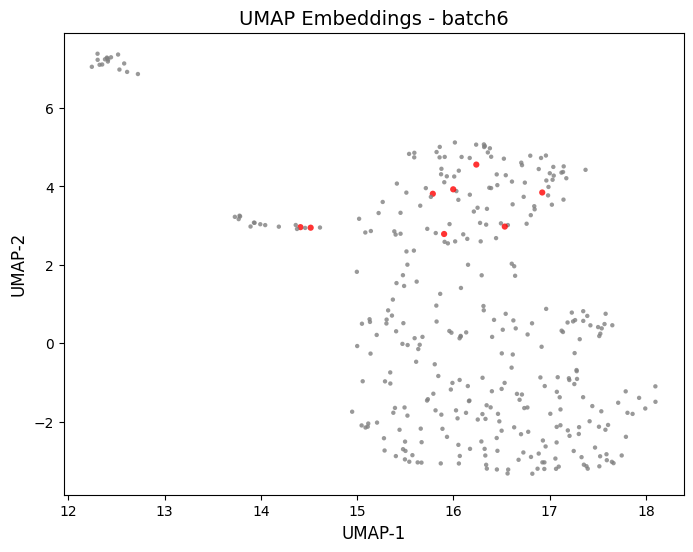

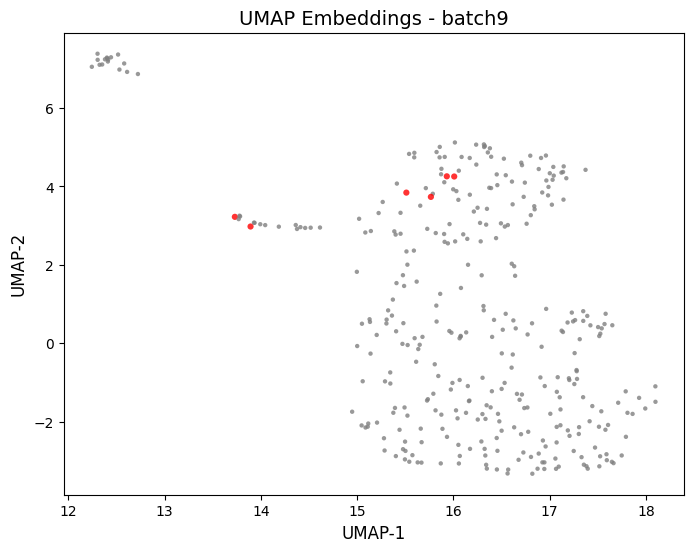

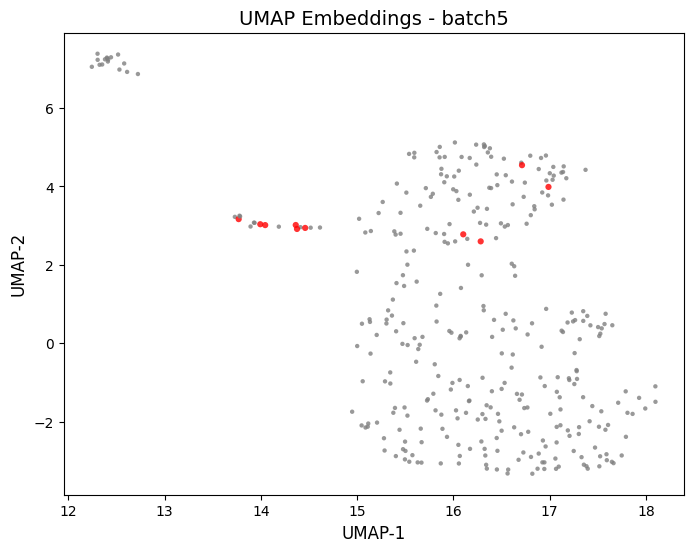

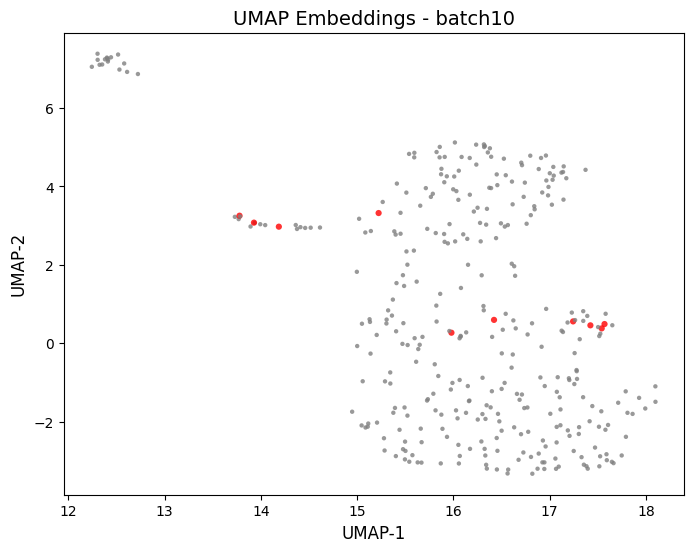

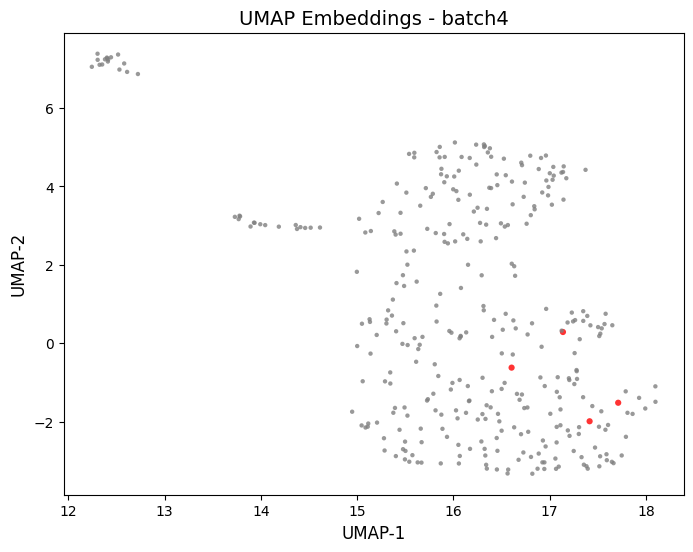

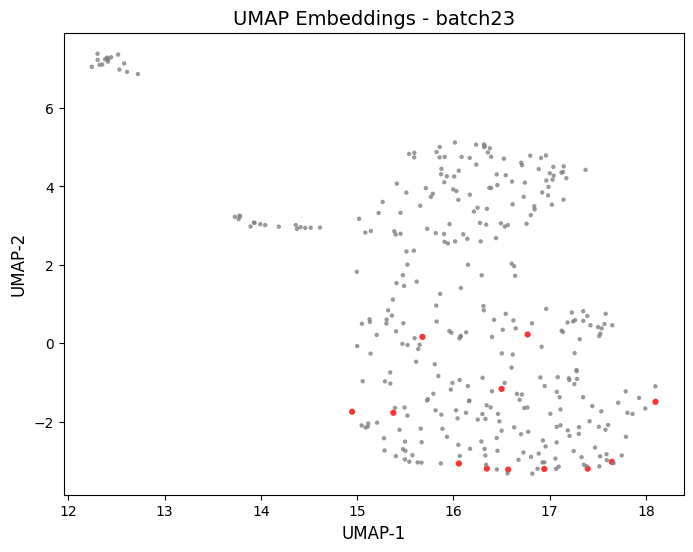

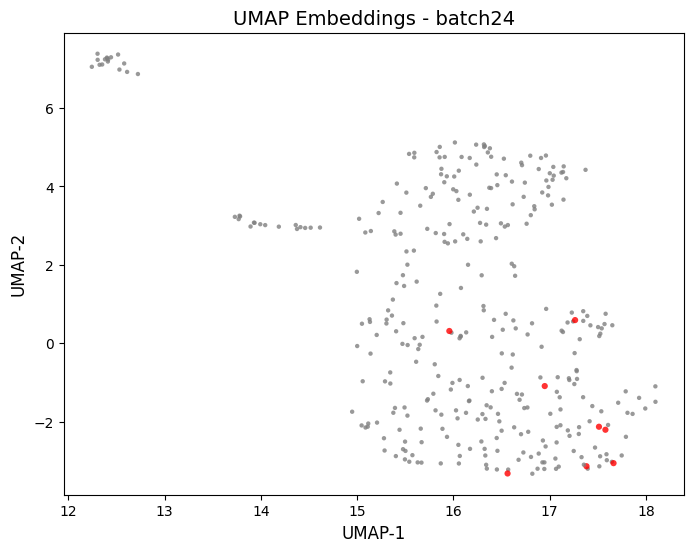

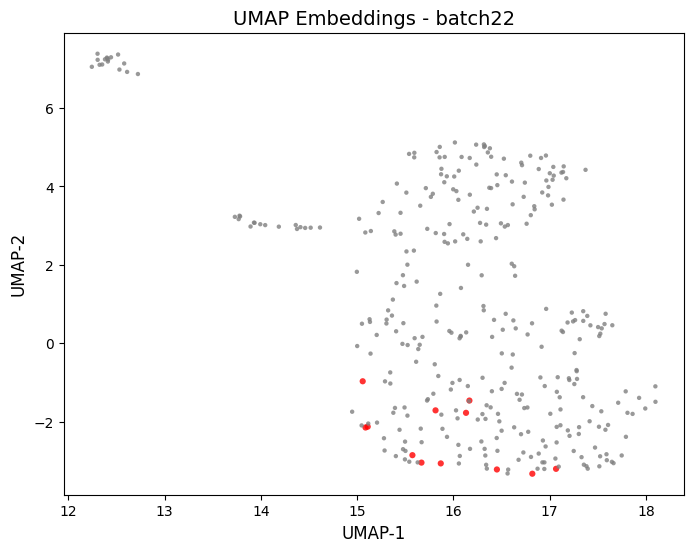

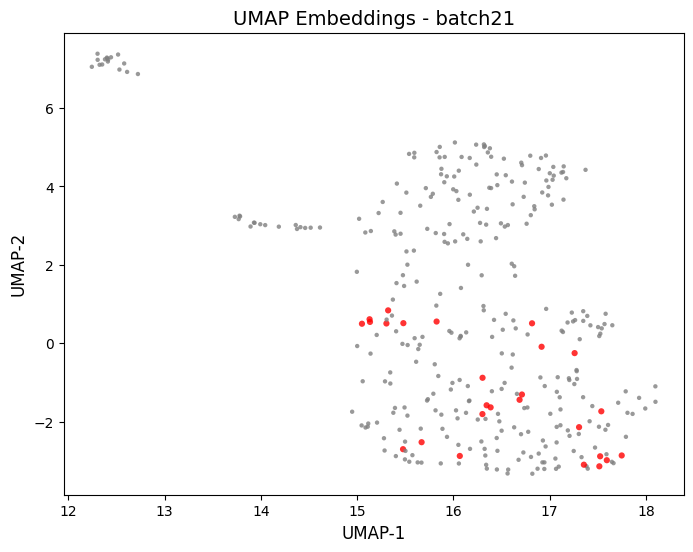

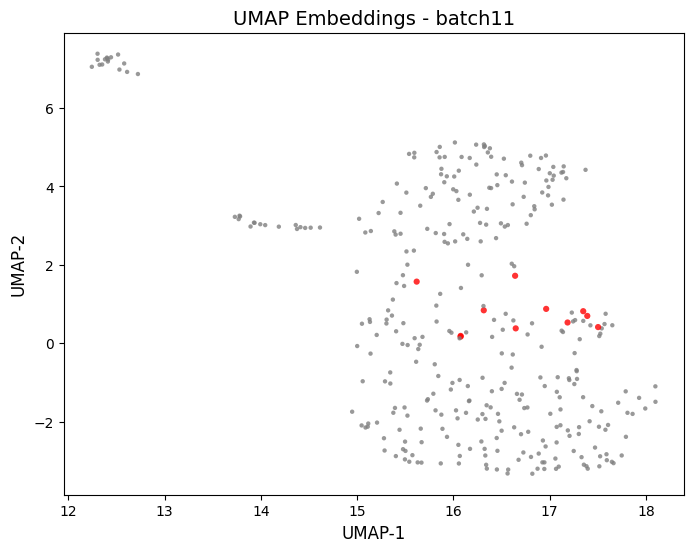

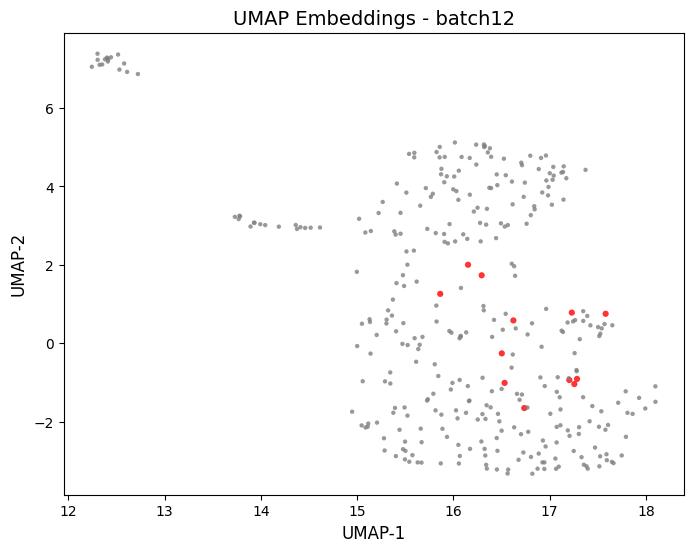

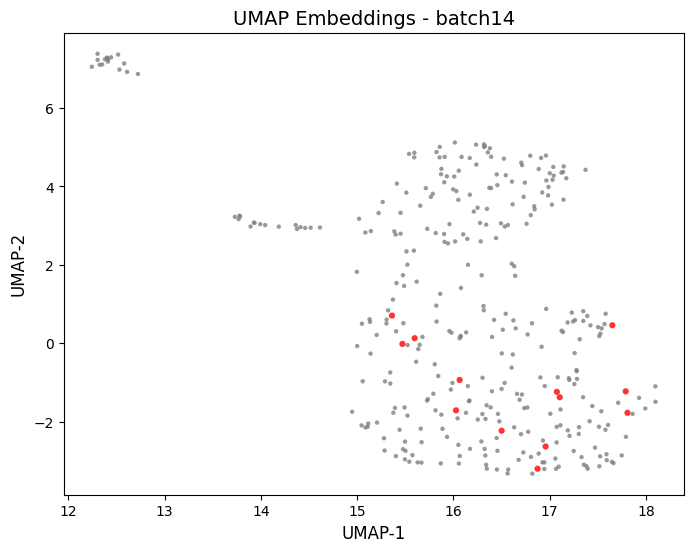

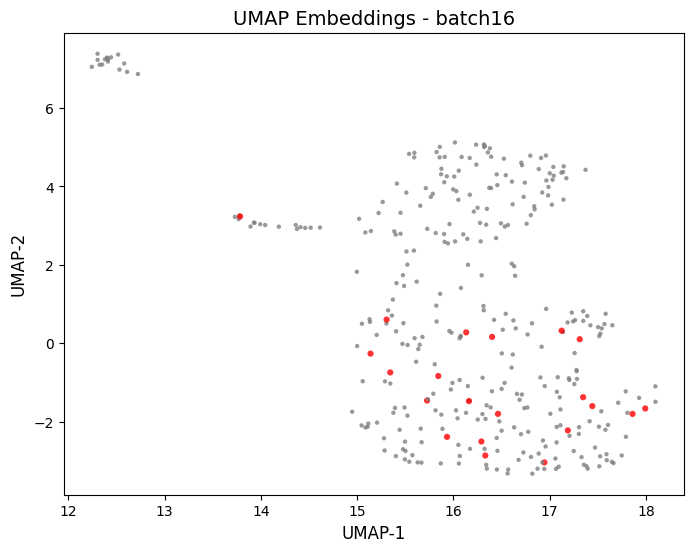

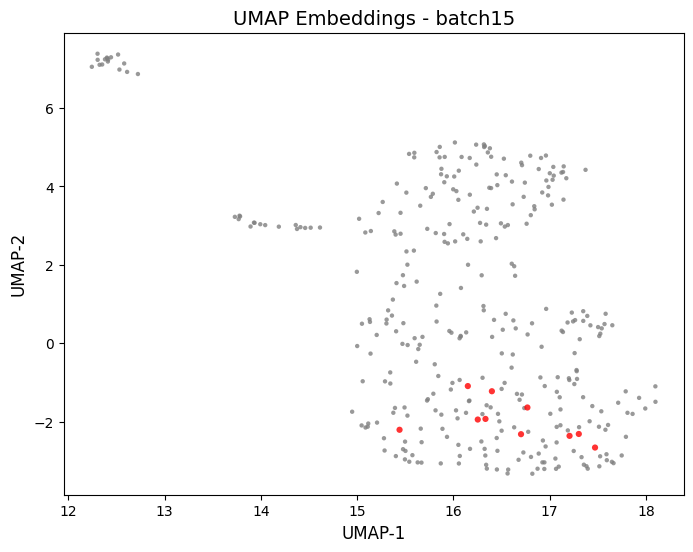

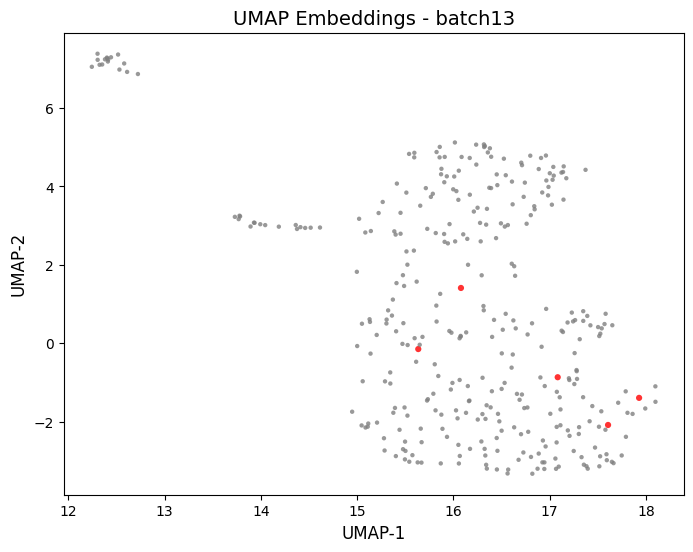

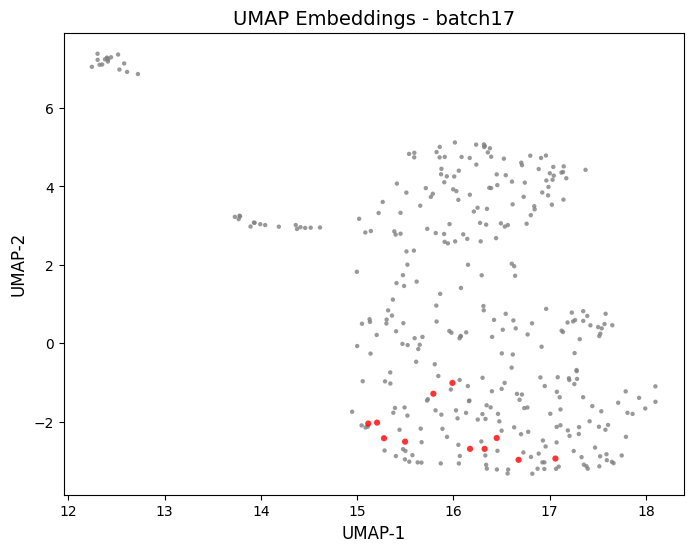

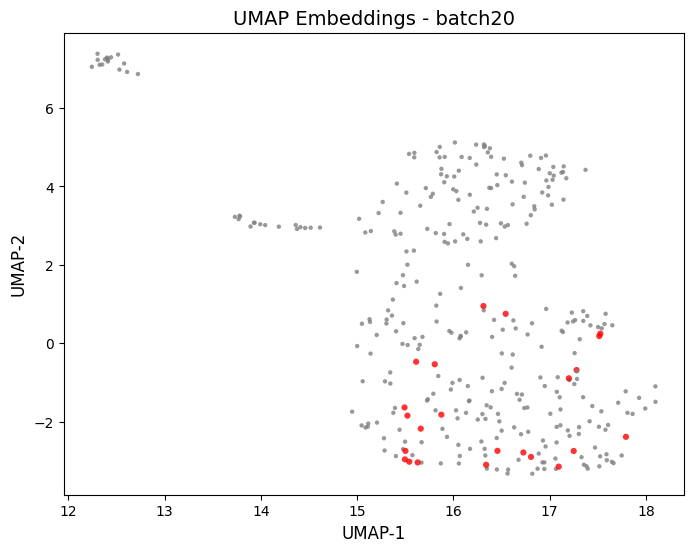

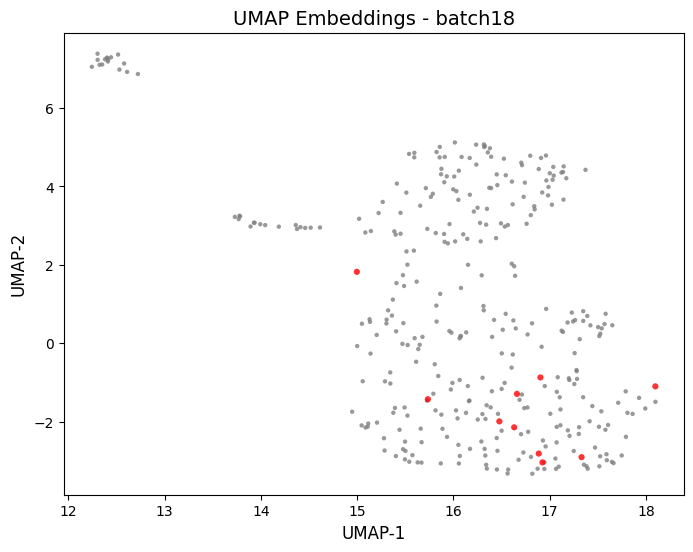

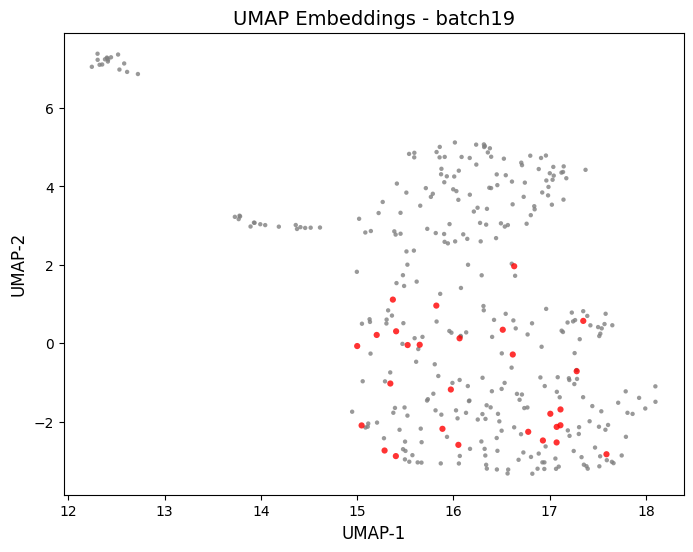

In [374]:
#IVF 500K 350cells 获取数据批次标签

# 加载标签数据
label = pd.read_csv('/home/lihaoxing/try_scHiCluster/IVF350_cell_batch.txt', sep='\t', header=None, index_col=0)
label['batch'] = ['_'.join(x.split('_')[:2]) for x in label.index]

#查看不同批次数据
# Plot UMAP embeddings with each cell type highlighted in red in separate subplots
unique_cell_types = label[1].unique()
print(unique_cell_types)
for cell_type in unique_cell_types:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlabel('UMAP-1', fontsize=12)
    ax.set_ylabel('UMAP-2', fontsize=12)
    ax.set_title(f'UMAP Embeddings - batch{cell_type}', fontsize=14)
    
    for i, curr_cell_type in enumerate(unique_cell_types):
        cell = (label[1] == curr_cell_type)
        if curr_cell_type == cell_type:
            ax.scatter(y[cell, 0], y[cell, 1], c='red', s=ds*2, edgecolors='none', alpha=0.8, label=curr_cell_type, rasterized=True)
        else:
            ax.scatter(y[cell, 0], y[cell, 1], c='gray', s=ds, edgecolors='none', alpha=0.8, label=curr_cell_type, rasterized=True)
    
    #ax.legend(title='Cell Type', fontsize=10)
    plt.show()
